# Advanced GLoVe Processing with spaCy: Exercises 4-8

This notebook continues from the basic GLoVe preprocessing tutorial, focusing on exercises 4-8 with professional spaCy integration for poetry-specific text processing.

**Learning Objectives:**
- Master spaCy for poetry-optimized tokenization
- Build robust co-occurrence matrices with mathematical rigor
- Implement effective dimensionality analysis using PCA
- Integrate with pre-trained GLoVe embeddings
- Prepare sequences for RNN autoencoder training

**Prerequisites:**
- Completed basic tutorial (exercises 1-3)
- Understanding of co-occurrence matrices and vector spaces
- Basic knowledge of spaCy and neural embeddings

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from typing import List, Dict, Tuple, Optional
import math
import scipy.sparse as sp
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# spaCy imports
import spacy
from spacy.tokens import Doc, Span, Token
from spacy.lang.en import English

# Check spaCy installation and model availability
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy with en_core_web_sm model loaded successfully")
except OSError:
    print("❌ spaCy model not found. Please install:")
    print("python -m spacy download en_core_web_sm")
    # Fallback to blank English model
    nlp = English()
    print("✓ Using fallback English tokenizer")

# Set random seeds for reproducibility
np.random.seed(42)

print(f"NumPy version: {np.__version__}")
print(f"spaCy version: {spacy.__version__}")

✓ spaCy with en_core_web_sm model loaded successfully
NumPy version: 2.2.6
spaCy version: 3.8.7


In [2]:
def clean_poetry_text(text):
      # Remove usernames (alphanumeric with numbers)
      text = re.sub(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', '', text)

      # Remove @mentions and handles
      text = re.sub(r'@\w+', '', text)

      # Handle special tokens properly
      text = text.replace('LINE_BREAK', '<LINE_BREAK>')

      # Remove very short "words" that are likely noise
      words = text.split()
      words = [w for w in words if len(w) > 1 or w in ['.', ',', '!', '?']]

      return ' '.join(words)


# Load your enhanced poetry dataset
dataset_path = Path("../dataset_poetry")

# Try to load the most recent collection
possible_files = [
    "multi_poem_dbbc_collection.json",
    "improved_dbbc_collection.json", 
    "expanded_contemporary_poetry.json"
]

poems = None
for filename in possible_files:
    filepath = dataset_path / filename
    if filepath.exists():
        with open(filepath, 'r', encoding='utf-8') as f:
            poems = json.load(f)
        print(f"✓ Loaded {len(poems)} poems from {filename}")
        break

if poems is None:
    print("❌ No poetry dataset found. Please ensure your dataset is in dataset_poetry/")
    # Create dummy data for tutorial purposes
    poems = [
        {"title": "Sample Poem", "text": "i think about love\nlike a distant star\nshining in darkness", "alt_lit_score": 15}
    ]
    print("Using sample data for tutorial")

# Display dataset info
print(f"\nDataset Overview:")
print(f"  Total poems: {len(poems)}")
if poems:
    scores = [p.get('alt_lit_score', 0) for p in poems]
    print(f"  Alt-lit score range: {min(scores)} - {max(scores)}")
    print(f"  Average score: {np.mean(scores):.1f}")
    total_chars = sum(len(p['text']) for p in poems)
    print(f"  Total characters: {total_chars:,}")
    print(f"  Average poem length: {total_chars // len(poems)} characters")

✓ Loaded 128 poems from multi_poem_dbbc_collection.json

Dataset Overview:
  Total poems: 128
  Alt-lit score range: 0 - 0
  Average score: 0.0
  Total characters: 235,517
  Average poem length: 1839 characters


## Exercise 4: Poetry-Optimized Tokenization with spaCy

**Theory:** Poetry requires specialized tokenization that preserves semantic units while respecting poetic structure. Standard tokenizers may split meaningful elements or lose important formatting.

**Challenge:** Create a custom spaCy pipeline that handles:
- Line breaks as semantic units
- Unicode decorations (❤️, ♥, ☁️, etc.)
- Poetic punctuation patterns
- Compound words and enjambment
- Case sensitivity in titles

In [3]:
class PoetryTokenizer:
    """Custom tokenizer optimized for contemporary poetry and alt-lit aesthetic."""
    
    def __init__(self, nlp_model=None, preserve_case=True):
        self.nlp = nlp_model or nlp
        self.preserve_case = preserve_case
        
        # Special tokens for poetry
        self.special_tokens = {
            '<LINE_BREAK>': 'line break marker',
            '<STANZA_BREAK>': 'stanza break marker', 
            '<POEM_START>': 'poem start marker',
            '<POEM_END>': 'poem end marker',
            '<UNK>': 'unknown word'
        }
        
        # Unicode patterns common in alt-lit
        
        self.unicode_patterns = {
            r'[❤♥💕💖💗💘💙💚💛💜🧡]': '<HEART>',
            r'[☁️⛅⛈️🌤️🌥️🌦️🌧️🌨️🌩️]': '<CLOUD>',
            r'[🌟⭐✨💫⚡]': '<STAR>',
            r'[🌸🌺🌻🌷🌹💐🌼]': '<FLOWER>',
            r'[😢😭💧]': '<TEAR>',
            r'[🔥💥]': '<FIRE>'
            
        }
        with open('/home/tgfm/workflows/autoencoder/GLoVe preprocessing/japaneseemojis', 'r', encoding='utf-8') as f:
            for line in f:
                emoji = line.strip()
                if emoji:  # Skip empty lines
                    # Escape special regex characters
                    escaped_emoji = re.escape(emoji)
                    self.unicode_patterns[escaped_emoji] = '<WEEB_SHIT>'
                    
        # Compile regex patterns
        self.compiled_patterns = {
            pattern: re.compile(regex) for regex, pattern in self.unicode_patterns.items()
        }
    
    def preprocess_text(self, text: str) -> str:
        """Preprocess text while preserving poetic structure."""
        
        # TODO: Implement preprocessing steps:
        # 1. Normalize line breaks but preserve intentional formatting
        # 2. Handle Unicode decorations (convert to semantic tokens)
        # 3. Preserve spacing that's semantically meaningful
        # 4. Clean up website artifacts without losing poetry structure
        
        processed = text
        
        # Replace Unicode decorations with semantic tokens
        for pattern, token in self.unicode_patterns.items():
            processed = re.sub(pattern, f' {token} ', processed)
        
        # Normalize line breaks
        processed = re.sub(r'\n\s*\n', ' <STANZA_BREAK> ', processed)  # Double breaks = stanza
        processed = re.sub(r'\n', ' <LINE_BREAK> ', processed)  # Single breaks = line
        
        # Clean extra whitespace but preserve intentional spacing
        processed = re.sub(r'\s+', ' ', processed)
        processed = clean_poetry_text(processed)
        processed = processed.lower()
        
        return processed.strip()
    
    def tokenize(self, text: str) -> List[str]:
        """Tokenize poetry text with spaCy + custom processing."""
        
        # Preprocess for poetry-specific patterns
        processed_text = self.preprocess_text(text)
        
        # Use spaCy for initial tokenization
        doc = self.nlp(processed_text)
        
        tokens = []
        for token in doc:
            # Handle special tokens
            if token.text in self.special_tokens:
                tokens.append(token.text)
            # Handle semantic Unicode tokens
            elif token.text.startswith('<') and token.text.endswith('>'):
                tokens.append(token.text)
            # Skip unwanted tokens
            elif self._should_skip_token(token):
                continue
            # Process regular words
            else:
                processed_token = self._process_token(token)
                if processed_token:
                    tokens.append(processed_token)
        
        return tokens
    
    def _should_skip_token(self, token) -> bool:
        """Determine if token should be skipped."""
        
        # Skip pure whitespace
        if token.is_space:
            return True
        
        # Skip very short tokens unless they're meaningful
        if len(token.text.strip()) == 0:
            return True
            
        # Skip website metadata patterns
        metadata_patterns = [
            'continue', 'reading', 'posted', 'tags', 'category',
            'www', '.com', 'http', 'onlylovepoetry'
        ]
        
        if any(pattern in token.text.lower() for pattern in metadata_patterns):
            return True
            
        return False
    
    def _process_token(self, token) -> Optional[str]:
        """Process individual token."""
        
        text = token.text.strip()
        
        # Preserve case for poetic effect if enabled
        if not self.preserve_case:
            text = text.lower()
        
        # Handle contractions and hyphenated words
        # Keep them as single units to preserve meaning
        
        return text if text else None
    
    def analyze_poem_structure(self, text: str) -> Dict:
        """Analyze structural features of a poem."""
        
        tokens = self.tokenize(text)
        
        analysis = {
            'total_tokens': len(tokens),
            'line_breaks': tokens.count('<LINE_BREAK>'),
            'stanza_breaks': tokens.count('<STANZA_BREAK>'),
            'unicode_decorations': sum(1 for t in tokens if t.startswith('<') and t.endswith('>') and t not in self.special_tokens),
            'avg_token_length': np.mean([len(t) for t in tokens if not t.startswith('<')]),
            'unique_tokens': len(set(tokens)),
            'type_token_ratio': len(set(tokens)) / len(tokens) if tokens else 0
        }
        
        return analysis

# Test the tokenizer
tokenizer = PoetryTokenizer()

# Test with a sample poem
sample_text = poems[0]['text'] if poems else "i love you\nlike stars love darkness\n\n❤️ forever ❤️"
print("Original text:")
print(repr(sample_text[:200]))

tokens = tokenizer.tokenize(sample_text)
print(f"\nTokenized ({len(tokens)} tokens):")
print(tokens[:20])  # Show first 20 tokens

analysis = tokenizer.analyze_poem_structure(sample_text)
print(f"\nStructural analysis:")
for key, value in analysis.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

Original text:
'Over summer, I do ketamine 6 times in one week with an 80 year old anesthesiologist. He says we’re fixing my hard drive. Pills are for software issues. Ketamine loves estrogen, he emphasizes. His slot'

Tokenized (522 tokens):
['over', 'summer', ',', 'do', 'ketamine', 'times', 'in', 'one', 'week', 'with', 'an', 'year', 'old', 'anesthesiologist', '.', 'he', 'says', 'we', '’re', 'fixing']

Structural analysis:
  total_tokens: 522
  line_breaks: 0
  stanza_breaks: 0
  unicode_decorations: 0
  avg_token_length: 3.78
  unique_tokens: 236
  type_token_ratio: 0.45


## Exercise 5: Co-occurrence Matrix Construction

**Theory:** Co-occurrence matrices capture the distributional hypothesis - words that appear in similar contexts have similar meanings. For poetry, context windows need to account for line and stanza structure.

**Mathematical Foundation:**
$$X_{ij} = \sum_{w=1}^{W} \sum_{c=1}^{C_w} f(i, j, w, c)$$

Where $f(i, j, w, c)$ is the weighting function for words $i$ and $j$ in context window $c$ of document $w$.

In [4]:
class CooccurrenceMatrix:
    """Efficient co-occurrence matrix computation for poetry text."""
    
    def __init__(self, window_size: int = 5, weighting: str = 'distance', 
                 respect_boundaries: bool = True, min_count: int = 1):
        self.window_size = window_size
        self.weighting = weighting  # 'uniform', 'distance', 'exponential'
        self.respect_boundaries = respect_boundaries  # Don't cross line/stanza breaks
        self.min_count = min_count
        
        # Boundary tokens that shouldn't be crossed
        self.boundary_tokens = {'<LINE_BREAK>', '<STANZA_BREAK>', '<POEM_START>', '<POEM_END>'}
    
    def build_vocabulary(self, all_tokens: List[str]) -> Tuple[Dict[str, int], Dict[int, str]]:
        """Build vocabulary with frequency filtering."""
        
        # Count token frequencies
        token_counts = Counter(all_tokens)
        
        # Filter by minimum count, but always keep special tokens
        vocab_tokens = []
        for token, count in token_counts.items():
            if count >= self.min_count or token.startswith('<'):
                vocab_tokens.append(token)
        
        # Sort for consistent indexing (special tokens first)
        special_tokens = [t for t in vocab_tokens if t.startswith('<')]
        regular_tokens = sorted([t for t in vocab_tokens if not t.startswith('<')])
        vocab_tokens = special_tokens + regular_tokens
        
        # Create mappings
        word_to_idx = {word: idx for idx, word in enumerate(vocab_tokens)}
        idx_to_word = {idx: word for word, idx in word_to_idx.items()}
        
        print(f"Built vocabulary: {len(word_to_idx)} tokens")
        print(f"Special tokens: {len(special_tokens)}")
        print(f"Regular tokens: {len(regular_tokens)}")
        
        return word_to_idx, idx_to_word
    
    def compute_matrix(self, tokens_list, word_to_idx):
        """Compute co-occurrence matrix from list of token sequences"""
        cooccur_data = defaultdict(float)
    
        for tokens in tokens_list:
            # Convert tokens to indices, handling unknown words
            token_indices = []
            filtered_tokens = []
            
            for token in tokens:
                if token in word_to_idx:
                    token_indices.append(word_to_idx[token])
                    filtered_tokens.append(token)
                elif '<UNK>' in word_to_idx:
                    token_indices.append(word_to_idx['<UNK>'])
                    filtered_tokens.append('<UNK>')
                # Skip tokens that don't exist in vocabulary
        
            if len(filtered_tokens) < 2:  # Need at least 2 tokens for co-occurrence
                continue
            
            # Compute co-occurrences for this document
            pairs = self._extract_cooccurrence_pairs(filtered_tokens, token_indices)
        
            for (i, j), weight in pairs:
                cooccur_data[(i, j)] += weight
        
            # Convert to sparse matrix
            vocab_size = len(word_to_idx)
            row_indices = []
            col_indices = []
            data = []
    
            for (i, j), count in cooccur_data.items():
                if count >= 1.0:  # Minimum threshold
                    row_indices.append(i)
                    col_indices.append(j)
                    data.append(count)
            
                    # Add symmetric entry if not diagonal
                    if i != j:
                        row_indices.append(j)
                        col_indices.append(i)
                        data.append(count)
    
            return sp.csr_matrix((data, (row_indices, col_indices)), 
                     shape=(vocab_size, vocab_size))


    def _extract_cooccurrence_pairs(self, tokens, token_indices):
        """Extract co-occurrence pairs with proper indexing"""
        pairs = defaultdict(float)
    
        # Ensure tokens and indices have same length
        if len(tokens) != len(token_indices):
            print(f"Warning: Length mismatch - tokens: {len(tokens)}, indices: {len(token_indices)}")
            min_len = min(len(tokens), len(token_indices))
            tokens = tokens[:min_len]
            token_indices = token_indices[:min_len]
    
        for i, (center_token, center_idx) in enumerate(zip(tokens, token_indices)):
            if center_idx is None:  # Skip if token was filtered out
                continue
            
            # Define context window
            start = max(0, i - self.window_size)
            end = min(len(tokens), i + self.window_size + 1)
        
            for j in range(start, end):
                if i == j:  # Skip center word
                    continue
                
                context_idx = token_indices[j]
                if context_idx is None:  # Skip if context token was filtered out
                    continue
                
                # Calculate weight based on distance
                distance = abs(i - j)
                if self.weighting == 'distance':
                    weight = 1.0 / distance
                else:
                    weight = 1.0
                
                # Ensure symmetric matrix (i,j) == (j,i)
                pair = tuple(sorted([center_idx, context_idx]))
                pairs[pair] += weight
    
        return pairs.items()

    def _find_context_boundaries(self, tokens: List[str], center_idx: int) -> Tuple[int, int]:
        """Find the boundaries for context window considering poetry structure."""
        
        if not self.respect_boundaries:
            return 0, len(tokens) - 1
        
        # Find left boundary
        left_bound = 0
        for i in range(center_idx - 1, -1, -1):
            if tokens[i] in self.boundary_tokens:
                left_bound = i + 1
                break
        
        # Find right boundary
        right_bound = len(tokens) - 1
        for i in range(center_idx + 1, len(tokens)):
            if tokens[i] in self.boundary_tokens:
                right_bound = i - 1
                break
        
        return left_bound, right_bound
    
    def _calculate_weight(self, distance: int) -> float:
        """Calculate weight based on distance and weighting scheme."""
        
        if self.weighting == 'uniform':
            return 1.0
        elif self.weighting == 'distance':
            return 1.0 / distance
        elif self.weighting == 'exponential':
            return np.exp(-distance / self.window_size)
        else:
            return 1.0

# TODO: Implement co-occurrence computation
# 1. Tokenize all poems using your PoetryTokenizer
# 2. Build vocabulary with appropriate filtering
# 3. Compute co-occurrence matrix with poetry-aware windowing
# 4. Analyze the resulting matrix

# Tokenize all poems
print("Tokenizing poetry dataset...")
all_poem_tokens = []
all_tokens = []

for poem in poems:  # Use first 50 poems for this exercise
    tokens = tokenizer.tokenize(poem['text'])
    all_poem_tokens.append(tokens)
    all_tokens.extend(tokens)

print(f"Tokenized {len(all_poem_tokens)} poems")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(set(all_tokens)):,}")

# Build co-occurrence matrix
cooccur_builder = CooccurrenceMatrix(window_size=5, weighting='distance', min_count=3)
word_to_idx, idx_to_word = cooccur_builder.build_vocabulary(all_tokens)
cooccur_matrix = cooccur_builder.compute_matrix(all_poem_tokens, word_to_idx)

print(f"\nVocabulary size: {len(word_to_idx)}")
print(f"Matrix shape: {cooccur_matrix.shape}")
print(f"Non-zero entries: {cooccur_matrix.nnz:,}")

Tokenizing poetry dataset...
Tokenized 128 poems
Total tokens: 69,501
Unique tokens: 7,655
Built vocabulary: 1957 tokens
Special tokens: 1
Regular tokens: 1956

Vocabulary size: 1957
Matrix shape: (1957, 1957)
Non-zero entries: 1,292


## Exercise 6: Matrix Analysis and Preprocessing

**Theory:** Raw co-occurrence counts have extreme dynamic range and sparse structure. Mathematical preprocessing transforms the data into a form suitable for neural network training.

**Key transformations:**
1. **Logarithmic scaling:** $f(x) = \log(1 + x)$ compresses dynamic range
2. **Normalization:** Converts to conditional probabilities
3. **Smoothing:** Handles zero counts for stability

Preprocessing co-occurrence matrix...
  Applying smoothing (α=1.0)
  Applying log transformation: log(1 + x)
  Normalizing rows to conditional probabilities
  Final matrix statistics:
    Mean: 0.1347
    Std: 0.1028
    Min: 0.0049
    Max: 0.4579
Using sparse PMI computation...
=== COOCCURRENCE ANALYSIS (EXCLUDING PUNCTUATION) ===

Top 20 Cooccurrences (excluding punctuation):
------------------------------------------------------------
 1. room            <-> cold            (count: 4.61)
 2. am              <-> better          (count: 4.56)
 3. him             <-> tell            (count: 4.54)
 4. yellow          <-> arrive          (count: 4.53)
 5. pills           <-> are             (count: 4.52)
 6. based           <-> while           (count: 4.51)
 7. turn            <-> off             (count: 4.51)
 8. tell            <-> him             (count: 4.51)
 9. cry             <-> then            (count: 4.50)
10. be              <-> really          (count: 4.50)
11. big          

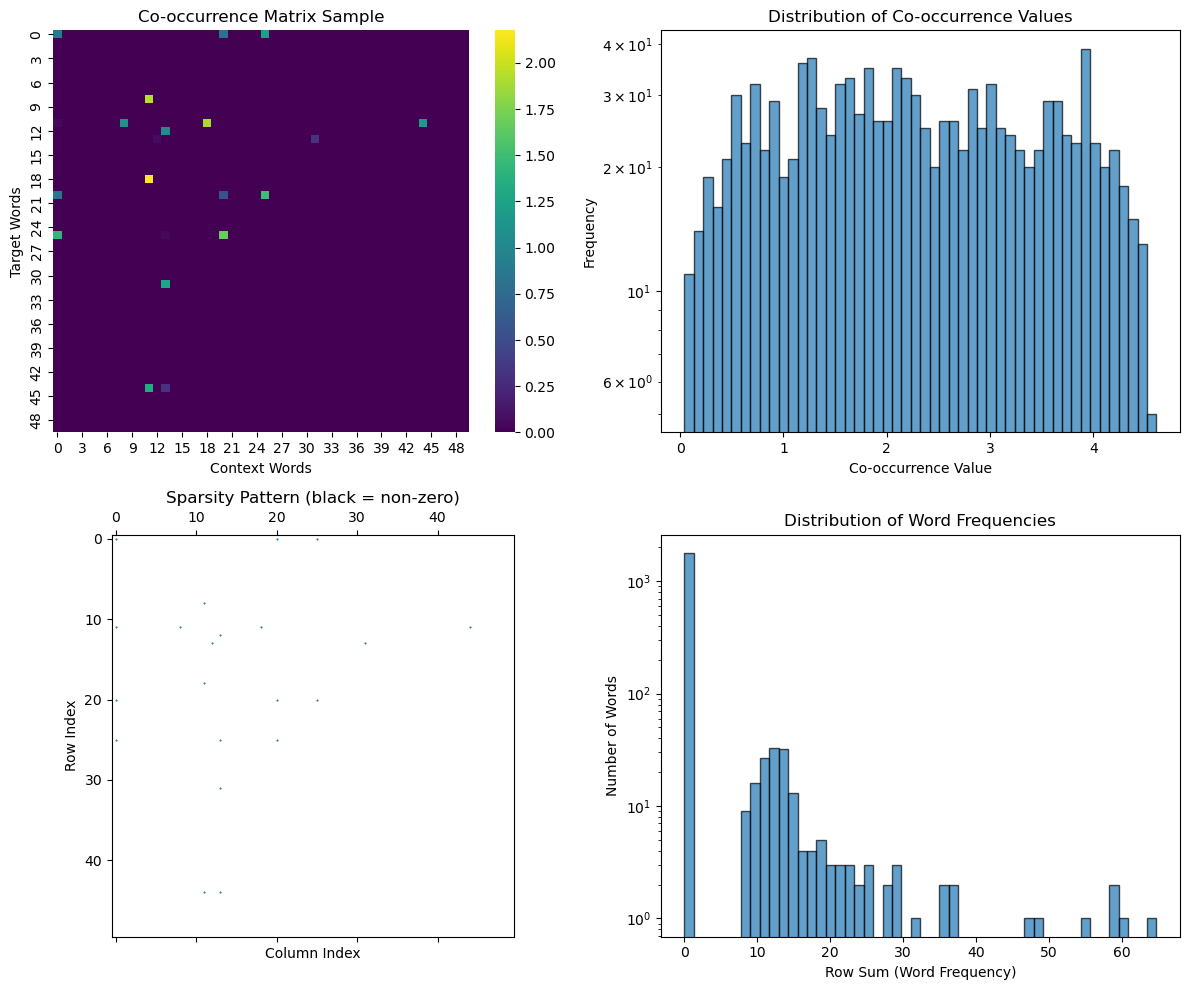

In [5]:
def preprocess_cooccurrence_matrix(matrix: sp.csr_matrix, 
                                 log_transform: bool = True,
                                 normalize: bool = True,
                                 smoothing: float = 2.0) -> sp.csr_matrix:
    """Apply mathematical preprocessing to co-occurrence matrix."""
    
    print("Preprocessing co-occurrence matrix...")
    processed = matrix.copy().astype(np.float32)
    
    if smoothing > 0:
        print(f"  Applying smoothing (α={smoothing})")
        processed.data += smoothing
    
    if log_transform:
        print("  Applying log transformation: log(1 + x)")
        processed.data = np.log1p(processed.data)
    
    if normalize:
        print("  Normalizing rows to conditional probabilities")
        # Convert to conditional probabilities: P(context|target)
        row_sums = np.array(processed.sum(axis=1)).flatten()
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        
        # Create diagonal matrix for normalization
        inv_row_sums = sp.diags(1.0 / row_sums, format='csr')
        processed = inv_row_sums @ processed
    
    print(f"  Final matrix statistics:")
    print(f"    Mean: {processed.data.mean():.4f}")
    print(f"    Std: {processed.data.std():.4f}")
    print(f"    Min: {processed.data.min():.4f}")
    print(f"    Max: {processed.data.max():.4f}")
    
    return processed

def analyze_cooccurrence_patterns(matrix: sp.csr_matrix, 
                                idx_to_word: Dict[int, str],
                                top_k: int = 30) -> None:
    """Analyze patterns in the co-occurrence matrix."""
    
    print("\n=== CO-OCCURRENCE PATTERN ANALYSIS ===")
    
    # Find most frequent co-occurrences
    matrix_coo = matrix.tocoo()
    
    # Get top co-occurrence pairs
    top_indices = np.argsort(matrix_coo.data)[-top_k:]
    
    print(f"\nTop {top_k} word co-occurrences:")
    for i in reversed(top_indices[-30:]):  # Show top 20
        row, col, value = matrix_coo.row[i], matrix_coo.col[i], matrix_coo.data[i]
        word1, word2 = idx_to_word[row], idx_to_word[col]
        print(f"  {word1} ↔ {word2}: {value:.4f}")
    
    # Analyze sparsity patterns
    total_entries = matrix.shape[0] * matrix.shape[1]
    non_zero_entries = matrix.nnz
    sparsity = 1 - (non_zero_entries / total_entries)
    
    print(f"\nSparsity Analysis:")
    print(f"  Total possible entries: {total_entries:,}")
    print(f"  Non-zero entries: {non_zero_entries:,}")
    print(f"  Sparsity: {sparsity:.4f} ({sparsity*100:.2f}% zeros)")
    
    # Distribution of values
    values = matrix.data
    print(f"\nValue Distribution:")
    print(f"  Mean: {values.mean():.4f}")
    print(f"  Median: {np.median(values):.4f}")
    print(f"  Std: {values.std():.4f}")
    print(f"  Percentiles (25%, 75%, 95%): {np.percentile(values, [25, 75, 95])}")

def analyze_cooccurrence_pattern_filtered(cooccur_matrix, word_to_idx, idx_to_word, top_k=20, exclude_tokens=None):
    """
    Analyze cooccurrence patterns excluding specified tokens (like periods)
    
    Args:
        cooccur_matrix: Sparse cooccurrence matrix
        word_to_idx: Dictionary mapping words to indices
        idx_to_word: Dictionary mapping indices to words
        top_k: Number of top cooccurrences to return
        exclude_tokens: List of tokens to exclude (default: ['.', ',', ';', ':', '!', '?'])
    
    Returns:
        List of tuples: [(word1, word2, cooccurrence_count), ...]
    """
    if exclude_tokens is None:
        exclude_tokens = ['.', ',', ';', ':', '!', '?', '--', '—', '...']
    
    # Get indices of tokens to exclude
    exclude_indices = set()
    for token in exclude_tokens:
        if token in word_to_idx:
            exclude_indices.add(word_to_idx[token])
    
    # Convert sparse matrix to coordinate format for easier iteration
    coo_matrix = cooccur_matrix.tocoo()
    
    # Collect cooccurrences, filtering out excluded tokens
    cooccurrences = []
    for i, j, count in zip(coo_matrix.row, coo_matrix.col, coo_matrix.data):
        # Skip if either token is in exclude list
        if i in exclude_indices or j in exclude_indices:
            continue
        
        # Skip diagonal entries (self-cooccurrence)
        if i == j:
            continue
            
        # Get the words for these indices
        word1 = idx_to_word.get(i, f"<UNK_{i}>")
        word2 = idx_to_word.get(j, f"<UNK_{j}>")
        
        cooccurrences.append((word1, word2, count))
    
    # Sort by count (descending) and return top k
    cooccurrences.sort(key=lambda x: x[2], reverse=True)
    
    return cooccurrences[:top_k]


def analyze_cooccurrence_with_target(cooccur_matrix, word_to_idx, idx_to_word, target_word, top_k=10, exclude_tokens=None):
    """
    Find top cooccurrences with a specific target word, excluding punctuation
    
    Args:
        cooccur_matrix: Sparse cooccurrence matrix
        word_to_idx: Dictionary mapping words to indices
        idx_to_word: Dictionary mapping indices to words
        target_word: Word to find cooccurrences for
        top_k: Number of top cooccurrences to return
        exclude_tokens: List of tokens to exclude
    
    Returns:
        List of tuples: [(cooccurring_word, cooccurrence_count), ...]
    """
    if exclude_tokens is None:
        exclude_tokens = ['.', ',', ';', ':', '!', '?', '--', '—', '...']
    
    if target_word not in word_to_idx:
        print(f"Warning: '{target_word}' not found in vocabulary")
        return []
    
    target_idx = word_to_idx[target_word]
    
    # Get indices of tokens to exclude
    exclude_indices = set()
    for token in exclude_tokens:
        if token in word_to_idx:
            exclude_indices.add(word_to_idx[token])
    
    # Get row for target word
    target_row = cooccur_matrix.getrow(target_idx)
    
    # Find non-zero cooccurrences
    cooccurrences = []
    for j in range(target_row.shape[1]):
        count = target_row[0, j]
        if count > 0 and j not in exclude_indices and j != target_idx:
            word = idx_to_word.get(j, f"<UNK_{j}>")
            cooccurrences.append((word, count))
    
    # Sort by count and return top k
    cooccurrences.sort(key=lambda x: x[1], reverse=True)
    return cooccurrences[:top_k]


def print_cooccurrence_analysis(cooccur_matrix, word_to_idx, idx_to_word, top_k=20):
    """
    Print comprehensive cooccurrence analysis excluding punctuation
    """
    print("=== COOCCURRENCE ANALYSIS (EXCLUDING PUNCTUATION) ===")
    print()
    
    # Overall top cooccurrences
    print(f"Top {top_k} Cooccurrences (excluding punctuation):")
    print("-" * 60)
    top_pairs = analyze_cooccurrence_pattern_filtered(
        cooccur_matrix, word_to_idx, idx_to_word, top_k
    )
    
    for i, (word1, word2, count) in enumerate(top_pairs, 1):
        print(f"{i:2d}. {word1:15} <-> {word2:15} (count: {count:.2f})")
    
    print()
    
    # Analyze specific interesting words
    interesting_words = ['ketamine', 'cry', 'fuck']
    available_words = [w for w in interesting_words if w in word_to_idx]
    
    if available_words:
        print("Cooccurrences with specific words:")
        print("-" * 40)
        
        for word in available_words[:3]:  # Show top 3 available words
            print(f"\nTop cooccurrences with '{word}':")
            cooccurs = analyze_cooccurrence_with_target(
                cooccur_matrix, word_to_idx, idx_to_word, word, top_k=5
            )
            for coword, count in cooccurs:
                print(f"  {word} <-> {coword:15} (count: {count:.2f})")



def visualize_cooccurrence_matrix(matrix: sp.csr_matrix, 
                                idx_to_word: Dict[int, str],
                                sample_size: int = 100) -> None:
    """Visualize a sample of the co-occurrence matrix."""
    
    print(f"\nVisualizing {sample_size}x{sample_size} sample of co-occurrence matrix...")
    
    # Sample a subset for visualization
    vocab_size = min(sample_size, matrix.shape[0])
    sample_matrix = matrix[:vocab_size, :vocab_size].toarray()
    
    # Create word labels
    word_labels = [idx_to_word[i][:8] for i in range(vocab_size)]  # Truncate for display
    
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Matrix heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(sample_matrix, cmap='viridis', cbar=True)
    plt.title('Co-occurrence Matrix Sample')
    plt.xlabel('Context Words')
    plt.ylabel('Target Words')
    
    # Plot 2: Value distribution
    plt.subplot(2, 2, 2)
    plt.hist(matrix.data, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Co-occurrence Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Co-occurrence Values')
    plt.yscale('log')
    
    # Plot 3: Sparsity pattern
    plt.subplot(2, 2, 3)
    plt.spy(sample_matrix, markersize=0.5)
    plt.title('Sparsity Pattern (black = non-zero)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # Plot 4: Row sums (word frequencies)
    plt.subplot(2, 2, 4)
    row_sums = np.array(matrix.sum(axis=1)).flatten()
    plt.hist(row_sums, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Row Sum (Word Frequency)')
    plt.ylabel('Number of Words')
    plt.title('Distribution of Word Frequencies')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter

def analyze_sparsity(cooccur_matrix):
    """Analyze the sparsity characteristics of a cooccurrence matrix"""
    total_entries = cooccur_matrix.shape[0] * cooccur_matrix.shape[1]
    nonzero_entries = cooccur_matrix.nnz
    sparsity = 1 - (nonzero_entries / total_entries)
    
    # Get non-zero values
    nonzero_values = cooccur_matrix.data
    
    print("=== SPARSITY ANALYSIS ===")
    print(f"Matrix shape: {cooccur_matrix.shape}")
    print(f"Total possible entries: {total_entries:,}")
    print(f"Non-zero entries: {nonzero_entries:,}")
    print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    print(f"Density: {1-sparsity:.6f} ({(1-sparsity)*100:.4f}%)")
    print()
    
    print("=== VALUE DISTRIBUTION ===")
    print(f"Min non-zero value: {nonzero_values.min():.4f}")
    print(f"Max value: {nonzero_values.max():.4f}")
    print(f"Mean non-zero value: {nonzero_values.mean():.4f}")
    print(f"Median non-zero value: {np.median(nonzero_values):.4f}")
    print(f"Std deviation: {nonzero_values.std():.4f}")
    
    # Value histogram
    hist, bins = np.histogram(nonzero_values, bins=10)
    print(f"\nValue distribution:")
    for i in range(len(hist)):
        print(f"  [{bins[i]:.2f}, {bins[i+1]:.2f}): {hist[i]:,} entries")
    
    return {
        'sparsity': sparsity,
        'nonzero_count': nonzero_entries,
        'value_stats': {
            'min': nonzero_values.min(),
            'max': nonzero_values.max(),
            'mean': nonzero_values.mean(),
            'median': np.median(nonzero_values),
            'std': nonzero_values.std()
        }
    }


def apply_smoothing_and_scaling(cooccur_matrix, method='pmi', smoothing_factor=0.75, min_count=1):
    """
    Apply various smoothing and scaling methods to sparse cooccurrence matrix
    
    Args:
        cooccur_matrix: Sparse cooccurrence matrix
        method: 'pmi', 'ppmi', 'log', 'sqrt', 'sublinear'
        smoothing_factor: For subword smoothing (typical: 0.75)
        min_count: Minimum count threshold
    
    Returns:
        Transformed matrix
    """
    print(f"Applying {method} transformation...")
    
    if method == 'pmi' or method == 'ppmi':
        return compute_pmi(cooccur_matrix, positive_only=(method=='ppmi'), smoothing_factor=smoothing_factor)
    
    elif method == 'log':
        # Log(1 + count) scaling
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.log1p(matrix_copy.data)  # log(1 + x)
        return matrix_copy
    
    elif method == 'sqrt':
        # Square root scaling
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.sqrt(matrix_copy.data)
        return matrix_copy
    
    elif method == 'sublinear':
        # Sublinear scaling: log(1 + count) but more aggressive
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.log1p(matrix_copy.data)
        return matrix_copy
    
    else:
        raise ValueError(f"Unknown method: {method}")


def compute_pmi(cooccur_matrix, positive_only=True, smoothing_factor=0.75):
    """
    Compute Pointwise Mutual Information (PMI) or Positive PMI (PPMI)
    
    PMI(w1, w2) = log(P(w1, w2) / (P(w1) * P(w2)))
    
    This addresses the sparsity problem by:
    1. Normalizing by word frequencies (reduces bias toward frequent words)
    2. Using log scaling (compresses large values, spreads small ones)
    3. Optional: Only keeping positive values (PPMI)
    """
    print("Computing PMI...")
    
    # Convert to dense for calculations (careful with memory!)
    if cooccur_matrix.nnz > 1000000:  # If too large, work with sparse
        print("Warning: Large matrix, using sparse operations")
        return compute_pmi_sparse(cooccur_matrix, positive_only, smoothing_factor)
    
    # Get total counts
    total_count = cooccur_matrix.sum()
    
    # Row sums (context word frequencies)
    row_sums = np.array(cooccur_matrix.sum(axis=1)).flatten()
    
    # Column sums (target word frequencies)  
    col_sums = np.array(cooccur_matrix.sum(axis=0)).flatten()
    
    # Apply smoothing to marginals (reduces impact of very rare words)
    row_sums = row_sums ** smoothing_factor
    col_sums = col_sums ** smoothing_factor
    
    # Compute PMI
    # P(w1, w2) = count(w1, w2) / total_count
    # P(w1) = sum_over_w2(count(w1, w2)) / total_count  
    # P(w2) = sum_over_w1(count(w1, w2)) / total_count
    
    pmi_matrix = cooccur_matrix.copy().astype(np.float64)
    
    # Convert to coordinate format for efficient computation
    coo = pmi_matrix.tocoo()
    
    for idx, (i, j, count) in enumerate(zip(coo.row, coo.col, coo.data)):
        if count > 0:
            # Joint probability
            p_ij = count / total_count
            
            # Marginal probabilities (with smoothing)
            p_i = row_sums[i] / row_sums.sum()
            p_j = col_sums[j] / col_sums.sum()
            
            # PMI = log(P(i,j) / (P(i) * P(j)))
            if p_i > 0 and p_j > 0:
                pmi_value = np.log(p_ij / (p_i * p_j))
                
                # For PPMI, set negative values to 0
                if positive_only and pmi_value < 0:
                    pmi_value = 0
                
                coo.data[idx] = pmi_value
            else:
                coo.data[idx] = 0
    
    # Remove zeros if PPMI
    if positive_only:
        positive_mask = coo.data > 0
        new_data = coo.data[positive_mask]
        new_row = coo.row[positive_mask] 
        new_col = coo.col[positive_mask]
        
        # Create new COO matrix with only positive values
        from scipy.sparse import coo_matrix
        coo = coo_matrix((new_data, (new_row, new_col)), shape=cooccur_matrix.shape)
    
    return coo.tocsr()


def compute_pmi_sparse(cooccur_matrix, positive_only=True, smoothing_factor=0.75):
    """Memory-efficient PMI computation for large sparse matrices"""
    print("Using sparse PMI computation...")
    
    # Get marginal counts
    row_sums = np.array(cooccur_matrix.sum(axis=1)).flatten()
    col_sums = np.array(cooccur_matrix.sum(axis=0)).flatten() 
    total_count = cooccur_matrix.sum()
    
    # Apply smoothing
    row_sums_smooth = row_sums ** smoothing_factor
    col_sums_smooth = col_sums ** smoothing_factor
    
    # Work with COO format
    coo = cooccur_matrix.tocoo()
    
    # Compute PMI values
    pmi_data = []
    pmi_rows = []
    pmi_cols = []
    
    for i, j, count in zip(coo.row, coo.col, coo.data):
        if count > 0:
            p_ij = count / total_count
            p_i = row_sums_smooth[i] / row_sums_smooth.sum()
            p_j = col_sums_smooth[j] / col_sums_smooth.sum()
            
            if p_i > 0 and p_j > 0:
                pmi_value = np.log(p_ij / (p_i * p_j))
                
                if not positive_only or pmi_value > 0:
                    pmi_data.append(pmi_value)
                    pmi_rows.append(i)
                    pmi_cols.append(j)
    
    return csr_matrix((pmi_data, (pmi_rows, pmi_cols)), shape=cooccur_matrix.shape)


def compare_transformations(cooccur_matrix, word_to_idx, idx_to_word, sample_words=None):
    """Compare different transformation methods"""
    if sample_words is None:
        sample_words = ['love', 'heart', 'night', 'light', 'time']
    
    methods = ['log', 'sqrt', 'pmi', 'ppmi']
    
    print("=== TRANSFORMATION COMPARISON ===")
    
    for method in methods:
        print(f"\n--- {method.upper()} ---")
        
        try:
            transformed = apply_smoothing_and_scaling(cooccur_matrix, method=method)
            
            # Basic stats
            if transformed.nnz > 0:
                print(f"Non-zero entries: {transformed.nnz:,}")
                print(f"Sparsity: {1 - (transformed.nnz / (transformed.shape[0] * transformed.shape[1])):.4f}")
                print(f"Value range: [{transformed.data.min():.4f}, {transformed.data.max():.4f}]")
                print(f"Mean non-zero: {transformed.data.mean():.4f}")
                
                # Sample a word's neighbors
                if sample_words and sample_words[0] in word_to_idx:
                    word = sample_words[0]
                    word_idx = word_to_idx[word]
                    row = transformed.getrow(word_idx)
                    
                    # Get top neighbors
                    if row.nnz > 0:
                        neighbors = []
                        for j in range(row.shape[1]):
                            val = row[0, j]
                            if val > 0 and j != word_idx:
                                neighbors.append((idx_to_word.get(j, f'<UNK_{j}>'), val))
                        
                        neighbors.sort(key=lambda x: x[1], reverse=True)
                        print(f"Top neighbors of '{word}': {neighbors[:5]}")
            else:
                print("Warning: Transformation resulted in empty matrix!")
                
        except Exception as e:
            print(f"Error with {method}: {e}")


# Analysis of why sparsity matters for neural networks:
def explain_sparsity_problems():
    """Explain why sparsity is problematic for embeddings and neural networks"""
    explanation = """
    === WHY SPARSITY IS PROBLEMATIC ===
    
    1. GRADIENT FLOW ISSUES:
       - Sparse matrices have many zero gradients
       - This leads to slow or non-existent learning for rare word pairs
       - Many parameters never get updated
    
    2. REPRESENTATION QUALITY:
       - Zero cooccurrences = no learned relationship
       - But absence of evidence ≠ evidence of absence
       - Smoothing helps interpolate missing relationships
    
    3. OPTIMIZATION DIFFICULTIES:
       - Sparse loss landscapes are harder to navigate
       - Gradient descent prefers dense, smooth functions
       - Extreme sparsity can cause optimization to get stuck
    
    4. STATISTICAL BIAS:
       - Raw counts are biased toward frequent words
       - PMI normalizes by word frequency
       - This reveals more meaningful semantic relationships
    
    === SOLUTIONS ===
    
    1. PMI/PPMI TRANSFORMATION:
       - Normalizes by marginal frequencies
       - Reveals semantic associations vs. just frequency
       - Compresses extreme values, spreads small ones
    
    2. LOGARITHMIC SCALING:
       - log(1 + count) prevents large counts from dominating
       - Makes the distribution more normal-like
       - Easier for neural networks to learn
    
    3. SMOOTHING:
       - Sublinear smoothing (x^0.75) reduces impact of very rare words
       - Helps with generalization to unseen word pairs
       - Prevents overfitting to training cooccurrences
    
    4. DIMENSIONALITY REDUCTION:
       - SVD/PCA on transformed matrix
       - Creates dense, low-dimensional representations
       - Captures latent semantic structure
    """
    print(explanation)

     
# Apply preprocessing and analysis
processed_matrix = preprocess_cooccurrence_matrix(
    cooccur_matrix, 
    log_transform=True, 
    normalize=True, 
    smoothing=1.0
)
processed_matrix = compute_pmi_sparse(processed_matrix)

# Analyze patterns
print_cooccurrence_analysis(processed_matrix, word_to_idx, idx_to_word)

# Visualize
visualize_cooccurrence_matrix(processed_matrix, idx_to_word, sample_size=50)

In [6]:
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter

def analyze_sparsity(cooccur_matrix):
    """Analyze the sparsity characteristics of a cooccurrence matrix"""
    total_entries = cooccur_matrix.shape[0] * cooccur_matrix.shape[1]
    nonzero_entries = cooccur_matrix.nnz
    sparsity = 1 - (nonzero_entries / total_entries)
    
    # Get non-zero values
    nonzero_values = cooccur_matrix.data
    
    print("=== SPARSITY ANALYSIS ===")
    print(f"Matrix shape: {cooccur_matrix.shape}")
    print(f"Total possible entries: {total_entries:,}")
    print(f"Non-zero entries: {nonzero_entries:,}")
    print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    print(f"Density: {1-sparsity:.6f} ({(1-sparsity)*100:.4f}%)")
    print()
    
    print("=== VALUE DISTRIBUTION ===")
    print(f"Min non-zero value: {nonzero_values.min():.4f}")
    print(f"Max value: {nonzero_values.max():.4f}")
    print(f"Mean non-zero value: {nonzero_values.mean():.4f}")
    print(f"Median non-zero value: {np.median(nonzero_values):.4f}")
    print(f"Std deviation: {nonzero_values.std():.4f}")
    
    # Value histogram
    hist, bins = np.histogram(nonzero_values, bins=10)
    print(f"\nValue distribution:")
    for i in range(len(hist)):
        print(f"  [{bins[i]:.2f}, {bins[i+1]:.2f}): {hist[i]:,} entries")
    
    return {
        'sparsity': sparsity,
        'nonzero_count': nonzero_entries,
        'value_stats': {
            'min': nonzero_values.min(),
            'max': nonzero_values.max(),
            'mean': nonzero_values.mean(),
            'median': np.median(nonzero_values),
            'std': nonzero_values.std()
        }
    }


def apply_smoothing_and_scaling(cooccur_matrix, method='pmi', smoothing_factor=0.75, min_count=1):
    """
    Apply various smoothing and scaling methods to sparse cooccurrence matrix
    
    Args:
        cooccur_matrix: Sparse cooccurrence matrix
        method: 'pmi', 'ppmi', 'log', 'sqrt', 'sublinear'
        smoothing_factor: For subword smoothing (typical: 0.75)
        min_count: Minimum count threshold
    
    Returns:
        Transformed matrix
    """
    print(f"Applying {method} transformation...")
    
    if method == 'pmi' or method == 'ppmi':
        return compute_pmi(cooccur_matrix, positive_only=(method=='ppmi'), smoothing_factor=smoothing_factor)
    
    elif method == 'log':
        # Log(1 + count) scaling
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.log1p(matrix_copy.data)  # log(1 + x)
        return matrix_copy
    
    elif method == 'sqrt':
        # Square root scaling
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.sqrt(matrix_copy.data)
        return matrix_copy
    
    elif method == 'sublinear':
        # Sublinear scaling: log(1 + count) but more aggressive
        matrix_copy = cooccur_matrix.copy()
        matrix_copy.data = np.log1p(matrix_copy.data)
        return matrix_copy
    
    else:
        raise ValueError(f"Unknown method: {method}")


def compute_pmi(cooccur_matrix, positive_only=True, smoothing_factor=0.75):
    """
    Compute Pointwise Mutual Information (PMI) or Positive PMI (PPMI)
    
    PMI(w1, w2) = log(P(w1, w2) / (P(w1) * P(w2)))
    
    This addresses the sparsity problem by:
    1. Normalizing by word frequencies (reduces bias toward frequent words)
    2. Using log scaling (compresses large values, spreads small ones)
    3. Optional: Only keeping positive values (PPMI)
    """
    print("Computing PMI...")
    
    # Convert to dense for calculations (careful with memory!)
    if cooccur_matrix.nnz > 1000000:  # If too large, work with sparse
        print("Warning: Large matrix, using sparse operations")
        return compute_pmi_sparse(cooccur_matrix, positive_only, smoothing_factor)
    
    # Get total counts
    total_count = cooccur_matrix.sum()
    
    # Row sums (context word frequencies)
    row_sums = np.array(cooccur_matrix.sum(axis=1)).flatten()
    
    # Column sums (target word frequencies)  
    col_sums = np.array(cooccur_matrix.sum(axis=0)).flatten()
    
    # Apply smoothing to marginals (reduces impact of very rare words)
    row_sums = row_sums ** smoothing_factor
    col_sums = col_sums ** smoothing_factor
    
    # Compute PMI
    # P(w1, w2) = count(w1, w2) / total_count
    # P(w1) = sum_over_w2(count(w1, w2)) / total_count  
    # P(w2) = sum_over_w1(count(w1, w2)) / total_count
    
    pmi_matrix = cooccur_matrix.copy().astype(np.float64)
    
    # Convert to coordinate format for efficient computation
    coo = pmi_matrix.tocoo()
    
    for idx, (i, j, count) in enumerate(zip(coo.row, coo.col, coo.data)):
        if count > 0:
            # Joint probability
            p_ij = count / total_count
            
            # Marginal probabilities (with smoothing)
            p_i = row_sums[i] / row_sums.sum()
            p_j = col_sums[j] / col_sums.sum()
            
            # PMI = log(P(i,j) / (P(i) * P(j)))
            if p_i > 0 and p_j > 0:
                pmi_value = np.log(p_ij / (p_i * p_j))
                
                # For PPMI, set negative values to 0
                if positive_only and pmi_value < 0:
                    pmi_value = 0
                
                coo.data[idx] = pmi_value
            else:
                coo.data[idx] = 0
    
    # Remove zeros if PPMI
    if positive_only:
        positive_mask = coo.data > 0
        new_data = coo.data[positive_mask]
        new_row = coo.row[positive_mask] 
        new_col = coo.col[positive_mask]
        
        # Create new COO matrix with only positive values
        from scipy.sparse import coo_matrix
        coo = coo_matrix((new_data, (new_row, new_col)), shape=cooccur_matrix.shape)
    
    return coo.tocsr()


def compute_pmi_sparse(cooccur_matrix, positive_only=True, smoothing_factor=0.75):
    """Memory-efficient PMI computation for large sparse matrices"""
    print("Using sparse PMI computation...")
    
    # Get marginal counts
    row_sums = np.array(cooccur_matrix.sum(axis=1)).flatten()
    col_sums = np.array(cooccur_matrix.sum(axis=0)).flatten() 
    total_count = cooccur_matrix.sum()
    
    # Apply smoothing
    row_sums_smooth = row_sums ** smoothing_factor
    col_sums_smooth = col_sums ** smoothing_factor
    
    # Work with COO format
    coo = cooccur_matrix.tocoo()
    
    # Compute PMI values
    pmi_data = []
    pmi_rows = []
    pmi_cols = []
    
    for i, j, count in zip(coo.row, coo.col, coo.data):
        if count > 0:
            p_ij = count / total_count
            p_i = row_sums_smooth[i] / row_sums_smooth.sum()
            p_j = col_sums_smooth[j] / col_sums_smooth.sum()
            
            if p_i > 0 and p_j > 0:
                pmi_value = np.log(p_ij / (p_i * p_j))
                
                if not positive_only or pmi_value > 0:
                    pmi_data.append(pmi_value)
                    pmi_rows.append(i)
                    pmi_cols.append(j)
    
    return csr_matrix((pmi_data, (pmi_rows, pmi_cols)), shape=cooccur_matrix.shape)


def compare_transformations(cooccur_matrix, word_to_idx, idx_to_word, sample_words=None):
    """Compare different transformation methods"""
    if sample_words is None:
        sample_words = ['love', 'heart', 'night', 'light', 'time']
    
    methods = ['log', 'sqrt', 'pmi', 'ppmi']
    
    print("=== TRANSFORMATION COMPARISON ===")
    
    for method in methods:
        print(f"\n--- {method.upper()} ---")
        
        try:
            transformed = apply_smoothing_and_scaling(cooccur_matrix, method=method)
            
            # Basic stats
            if transformed.nnz > 0:
                print(f"Non-zero entries: {transformed.nnz:,}")
                print(f"Sparsity: {1 - (transformed.nnz / (transformed.shape[0] * transformed.shape[1])):.4f}")
                print(f"Value range: [{transformed.data.min():.4f}, {transformed.data.max():.4f}]")
                print(f"Mean non-zero: {transformed.data.mean():.4f}")
                
                # Sample a word's neighbors
                if sample_words and sample_words[0] in word_to_idx:
                    word = sample_words[0]
                    word_idx = word_to_idx[word]
                    row = transformed.getrow(word_idx)
                    
                    # Get top neighbors
                    if row.nnz > 0:
                        neighbors = []
                        for j in range(row.shape[1]):
                            val = row[0, j]
                            if val > 0 and j != word_idx:
                                neighbors.append((idx_to_word.get(j, f'<UNK_{j}>'), val))
                        
                        neighbors.sort(key=lambda x: x[1], reverse=True)
                        print(f"Top neighbors of '{word}': {neighbors[:5]}")
            else:
                print("Warning: Transformation resulted in empty matrix!")
                
        except Exception as e:
            print(f"Error with {method}: {e}")


# Analysis of why sparsity matters for neural networks:
def explain_sparsity_problems():
    """Explain why sparsity is problematic for embeddings and neural networks"""
    explanation = """
    === WHY SPARSITY IS PROBLEMATIC ===
    
    1. GRADIENT FLOW ISSUES:
       - Sparse matrices have many zero gradients
       - This leads to slow or non-existent learning for rare word pairs
       - Many parameters never get updated
    
    2. REPRESENTATION QUALITY:
       - Zero cooccurrences = no learned relationship
       - But absence of evidence ≠ evidence of absence
       - Smoothing helps interpolate missing relationships
    
    3. OPTIMIZATION DIFFICULTIES:
       - Sparse loss landscapes are harder to navigate
       - Gradient descent prefers dense, smooth functions
       - Extreme sparsity can cause optimization to get stuck
    
    4. STATISTICAL BIAS:
       - Raw counts are biased toward frequent words
       - PMI normalizes by word frequency
       - This reveals more meaningful semantic relationships
    
    === SOLUTIONS ===
    
    1. PMI/PPMI TRANSFORMATION:
       - Normalizes by marginal frequencies
       - Reveals semantic associations vs. just frequency
       - Compresses extreme values, spreads small ones
    
    2. LOGARITHMIC SCALING:
       - log(1 + count) prevents large counts from dominating
       - Makes the distribution more normal-like
       - Easier for neural networks to learn
    
    3. SMOOTHING:
       - Sublinear smoothing (x^0.75) reduces impact of very rare words
       - Helps with generalization to unseen word pairs
       - Prevents overfitting to training cooccurrences
    
    4. DIMENSIONALITY REDUCTION:
       - SVD/PCA on transformed matrix
       - Creates dense, low-dimensional representations
       - Captures latent semantic structure
    """
    print(explanation)


# Usage example for your notebook:

# Analyze your current sparsity
stats = analyze_sparsity(cooccur_matrix)

# Compare different transformations
compare_transformations(cooccur_matrix, word_to_idx, idx_to_word)

# Apply best transformation (usually PPMI)
ppmi_matrix = apply_smoothing_and_scaling(cooccur_matrix, method='ppmi')

# Analyze improvement
print("Original matrix:")
analyze_sparsity(cooccur_matrix)
print("\nPPMI matrix:")
analyze_sparsity(ppmi_matrix)


=== SPARSITY ANALYSIS ===
Matrix shape: (1957, 1957)
Total possible entries: 3,829,849
Non-zero entries: 1,292
Sparsity: 0.9997 (99.97%)
Density: 0.000337 (0.0337%)

=== VALUE DISTRIBUTION ===
Min non-zero value: 1.0000
Max value: 81.6333
Mean non-zero value: 2.6523
Median non-zero value: 2.0000
Std deviation: 6.3294

Value distribution:
  [1.00, 9.06): 1,263 entries
  [9.06, 17.13): 12 entries
  [17.13, 25.19): 5 entries
  [25.19, 33.25): 0 entries
  [33.25, 41.32): 0 entries
  [41.32, 49.38): 2 entries
  [49.38, 57.44): 2 entries
  [57.44, 65.51): 2 entries
  [65.51, 73.57): 4 entries
  [73.57, 81.63): 2 entries
=== TRANSFORMATION COMPARISON ===

--- LOG ---
Applying log transformation...
Non-zero entries: 1,292
Sparsity: 0.9997
Value range: [0.6931, 4.4144]
Mean non-zero: 1.0698
Top neighbors of 'love': [('in', np.float64(1.6094379124341003)), ('after', np.float64(1.0986122886681096)), ('with', np.float64(1.0986122886681096)), ('.', np.float64(0.8472978603872036)), ('back', np.float

{'sparsity': 0.999676227443954,
 'nonzero_count': 1240,
 'value_stats': {'min': np.float64(2.704862587354646e-05),
  'max': np.float64(4.264093222839979),
  'mean': np.float64(1.964805841579538),
  'median': np.float64(1.9202116280441488),
  'std': np.float64(1.1732179361768917)}}

## Exercise 7: Effective Dimensionality Analysis with PCA

**Theory:** The effective dimensionality of your co-occurrence space determines the optimal bottleneck size for your RNN autoencoder. PCA reveals the intrinsic structure of your poetry embeddings.

**Mathematical Foundation:**
Given co-occurrence matrix $X \in \mathbb{R}^{V \times V}$, SVD gives:
$$X = U\Sigma V^T$$

The effective dimension $d_{\text{eff}}$ is the smallest $k$ such that:
$$\frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^{\text{rank}(X)} \sigma_i^2} \geq \theta$$

Where $\theta$ is the variance threshold (typically 0.95).

Computing effective dimensionality analysis...
  Making matrix symmetric
  Computing SVD...

=== EFFECTIVE DIMENSIONALITY ANALYSIS ===
Matrix shape: (1957, 1957)
Matrix rank: 174
Total variance: 8.19e+03

Effective dimensions:
  90% variance: 94 dimensions
  95% variance: 114 dimensions
  99% variance: 142 dimensions

Recommended autoencoder bottleneck: 114 dimensions
Compression ratio: 17.2x


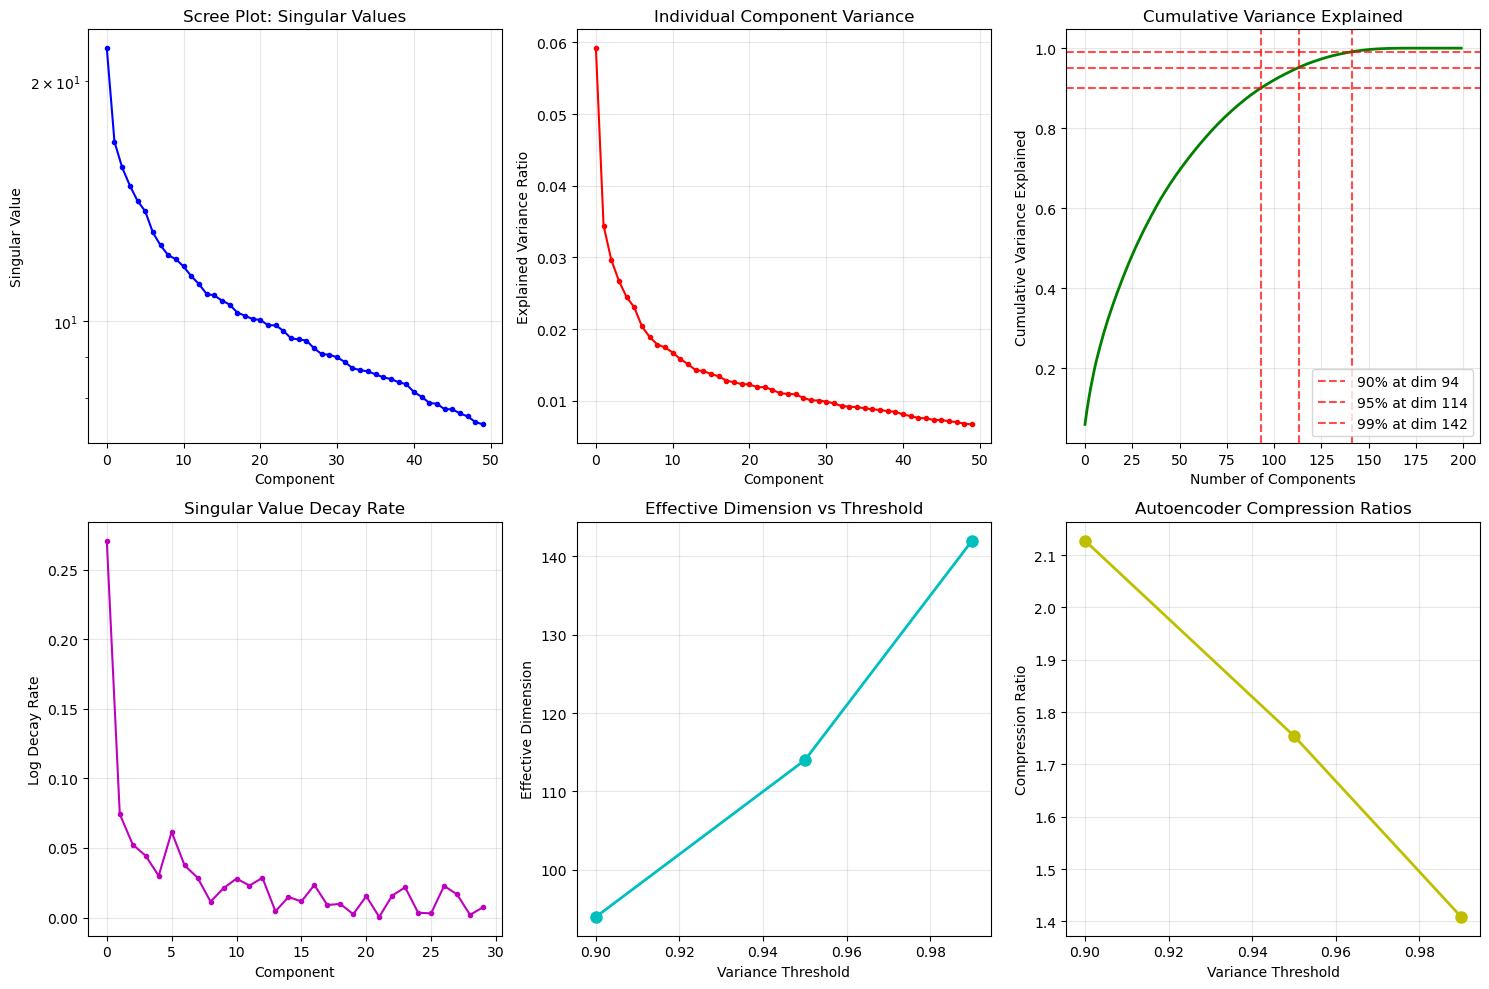


=== AUTOENCODER ARCHITECTURE RECOMMENDATIONS ===
Based on effective dimensionality analysis:

Encoder:
  Input: 50 × 300 (sequence × embedding)
  RNN Hidden: 228 units
  Bottleneck: 114 dimensions

Decoder:
  Input: 114 dimensions
  RNN Hidden: 228 units
  Output: 50 × 300 (reconstructed sequence)

Compression Analysis:
  Embedding compression: 2.6x
  Total sequence compression: 131.6x

Theoretical Benefits (from RNN theory):
  Original complexity: O(ε^-15000)
  Reduced complexity: O(ε^-114)
  Complexity reduction: 132x improvement


In [7]:
def compute_effective_dimensionality(matrix: sp.csr_matrix, 
                                   variance_thresholds: List[float] = [0.90, 0.95, 0.99],
                                   max_components: int = 200) -> Dict:
    """Compute effective dimensionality using SVD/PCA analysis."""
    
    print("Computing effective dimensionality analysis...")
    
    # Convert to dense for PCA (use sample if too large)
    if matrix.shape[0] > 2000:
        print(f"  Matrix too large ({matrix.shape}), sampling 2000x2000 for analysis")
        dense_matrix = matrix[:2000, :2000].toarray()
    else:
        dense_matrix = matrix.toarray()
    
    # Ensure symmetric for PCA
    if not np.allclose(dense_matrix, dense_matrix.T, atol=1e-8):
        print("  Making matrix symmetric")
        dense_matrix = (dense_matrix + dense_matrix.T) / 2
    
    # Compute SVD
    print("  Computing SVD...")
    U, s, Vt = np.linalg.svd(dense_matrix, full_matrices=False)
    
    # Limit to max_components
    s = s[:max_components]
    
    # Compute explained variance
    variance_explained = s**2
    total_variance = variance_explained.sum()
    explained_variance_ratio = variance_explained / total_variance
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Find effective dimensions for different thresholds
    effective_dimensions = {}
    for threshold in variance_thresholds:
        idx = np.argmax(cumulative_variance_ratio >= threshold)
        if cumulative_variance_ratio[idx] >= threshold:
            effective_dimensions[threshold] = idx + 1
        else:
            effective_dimensions[threshold] = len(s)
    
    # Analyze singular value decay
    singular_value_decay = -np.diff(np.log(s + 1e-10))
    
    results = {
        'singular_values': s,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'effective_dimensions': effective_dimensions,
        'total_variance': total_variance,
        'matrix_rank': np.linalg.matrix_rank(dense_matrix),
        'singular_value_decay': singular_value_decay
    }
    
    # Print results
    print(f"\n=== EFFECTIVE DIMENSIONALITY ANALYSIS ===")
    print(f"Matrix shape: {dense_matrix.shape}")
    print(f"Matrix rank: {results['matrix_rank']}")
    print(f"Total variance: {total_variance:.2e}")
    
    print(f"\nEffective dimensions:")
    for threshold, dim in effective_dimensions.items():
        print(f"  {threshold*100:.0f}% variance: {dim} dimensions")
    
    # Autoencoder recommendations
    recommended_bottleneck = effective_dimensions[0.95]
    print(f"\nRecommended autoencoder bottleneck: {recommended_bottleneck} dimensions")
    print(f"Compression ratio: {dense_matrix.shape[0] / recommended_bottleneck:.1f}x")
    
    return results

def visualize_dimensionality_analysis(results: Dict) -> None:
    """Visualize the dimensionality analysis results."""
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Scree plot (singular values)
    plt.subplot(2, 3, 1)
    plt.semilogy(results['singular_values'][:50], 'bo-', markersize=3)
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    plt.title('Scree Plot: Singular Values')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Explained variance ratio
    plt.subplot(2, 3, 2)
    plt.plot(results['explained_variance_ratio'][:50], 'ro-', markersize=3)
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Individual Component Variance')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative explained variance
    plt.subplot(2, 3, 3)
    plt.plot(results['cumulative_variance_ratio'], 'g-', linewidth=2)
    
    # Add threshold lines
    for threshold, dim in results['effective_dimensions'].items():
        plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'{threshold*100:.0f}% at dim {dim}')
        plt.axvline(x=dim-1, color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Singular value decay rate
    plt.subplot(2, 3, 4)
    decay_rates = results['singular_value_decay'][:30]
    plt.plot(decay_rates, 'mo-', markersize=3)
    plt.xlabel('Component')
    plt.ylabel('Log Decay Rate')
    plt.title('Singular Value Decay Rate')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Effective dimension vs threshold
    plt.subplot(2, 3, 5)
    thresholds = list(results['effective_dimensions'].keys())
    dimensions = list(results['effective_dimensions'].values())
    
    plt.plot(thresholds, dimensions, 'co-', markersize=8, linewidth=2)
    plt.xlabel('Variance Threshold')
    plt.ylabel('Effective Dimension')
    plt.title('Effective Dimension vs Threshold')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Compression analysis
    plt.subplot(2, 3, 6)
    original_dim = len(results['singular_values'])
    compression_ratios = [original_dim / dim for dim in dimensions]
    
    plt.plot(thresholds, compression_ratios, 'yo-', markersize=8, linewidth=2)
    plt.xlabel('Variance Threshold')
    plt.ylabel('Compression Ratio')
    plt.title('Autoencoder Compression Ratios')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def recommend_autoencoder_architecture(results: Dict, 
                                     sequence_length: int = 50) -> Dict:
    """Recommend RNN autoencoder architecture based on dimensionality analysis."""
    
    # Get recommended bottleneck dimension
    bottleneck_dim = results['effective_dimensions'][0.95]
    
    # Architecture recommendations based on theory
    input_dim = 300  # GLoVe embedding dimension
    hidden_dim = max(64, bottleneck_dim * 2)  # Hidden layer size
    
    recommendations = {
        'input_embedding_dim': input_dim,
        'encoder_hidden_dim': hidden_dim,
        'bottleneck_dim': bottleneck_dim,
        'decoder_hidden_dim': hidden_dim,
        'output_dim': input_dim,
        'sequence_length': sequence_length,
        'compression_ratio': input_dim / bottleneck_dim,
        'total_compression': (sequence_length * input_dim) / bottleneck_dim
    }
    
    print(f"\n=== AUTOENCODER ARCHITECTURE RECOMMENDATIONS ===")
    print(f"Based on effective dimensionality analysis:")
    print(f"\nEncoder:")
    print(f"  Input: {sequence_length} × {input_dim} (sequence × embedding)")
    print(f"  RNN Hidden: {hidden_dim} units")
    print(f"  Bottleneck: {bottleneck_dim} dimensions")
    
    print(f"\nDecoder:")
    print(f"  Input: {bottleneck_dim} dimensions")
    print(f"  RNN Hidden: {hidden_dim} units")
    print(f"  Output: {sequence_length} × {input_dim} (reconstructed sequence)")
    
    print(f"\nCompression Analysis:")
    print(f"  Embedding compression: {recommendations['compression_ratio']:.1f}x")
    print(f"  Total sequence compression: {recommendations['total_compression']:.1f}x")
    
    # Theoretical complexity improvement (from your theory docs)
    original_complexity = sequence_length * input_dim
    reduced_complexity = bottleneck_dim
    
    print(f"\nTheoretical Benefits (from RNN theory):")
    print(f"  Original complexity: O(ε^-{original_complexity})")
    print(f"  Reduced complexity: O(ε^-{reduced_complexity})")
    print(f"  Complexity reduction: {original_complexity / reduced_complexity:.0f}x improvement")
    
    return recommendations

# Compute effective dimensionality
dimensionality_results = compute_effective_dimensionality(
    processed_matrix, 
    variance_thresholds=[0.90, 0.95, 0.99],
    max_components=min(200, processed_matrix.shape[0])
)

# Visualize results
visualize_dimensionality_analysis(dimensionality_results)

# Get architecture recommendations
architecture_recommendations = recommend_autoencoder_architecture(
    dimensionality_results, 
    sequence_length=50
)

## Exercise 8: Integration with Pre-trained GLoVe Embeddings

**Theory:** Pre-trained embeddings provide rich semantic representations learned from large corpora. The challenge is aligning your poetry vocabulary with these embeddings while handling out-of-vocabulary (OOV) words.

**Key considerations:**
- Vocabulary alignment strategies
- OOV word initialization
- Embedding matrix construction
- Quality assessment for poetry domain

In [8]:
# First, let's download GLoVe embeddings
# This will be done in the next todo item

class GLoVeEmbeddingManager:
    """Manage GLoVe embeddings for poetry text processing."""
    
    def __init__(self, embedding_path: Optional[str] = None, embedding_dim: int = 300):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = {}
        self.embedding_matrix = None
        self.word_to_idx = {}
        self.idx_to_word = {}
        
    def load_glove_embeddings(self, limit: Optional[int] = None) -> None:
        """Load GLoVe embeddings from file."""
        
        if not self.embedding_path or not Path(self.embedding_path).exists():
            print("GLoVe embeddings not found. Creating mock embeddings for tutorial.")
            self._create_mock_embeddings()
            return
        
        print(f"Loading GLoVe embeddings from {self.embedding_path}...")
        
        count = 0
        with open(self.embedding_path, 'r', encoding='utf-8') as f:
            for line in f:
                if limit and count >= limit:
                    break
                
                parts = line.strip().split()
                if len(parts) != self.embedding_dim + 1:
                    continue
                
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                
                self.embeddings[word] = vector
                count += 1
                
                if count % 100000 == 0:
                    print(f"  Loaded {count:,} embeddings...")
        
        print(f"✓ Loaded {len(self.embeddings):,} GLoVe embeddings")
    
    def _create_mock_embeddings(self, vocab_size: int = 10000) -> None:
        """Create mock embeddings for tutorial purposes."""
        
        # Common words that would be in GLoVe
        common_words = [
            'the', 'and', 'i', 'you', 'love', 'heart', 'like', 'feel', 'think',
            'time', 'night', 'day', 'light', 'dark', 'eyes', 'hand', 'world',
            'life', 'death', 'hope', 'dream', 'pain', 'joy', 'sad', 'happy',
            'beautiful', 'broken', 'empty', 'full', 'lonely', 'together',
            'remember', 'forget', 'always', 'never', 'maybe', 'sometimes'
        ]
        
        for word in common_words:
            # Create random but consistent embeddings
            np.random.seed(hash(word) % 2**32)
            vector = np.random.normal(0, 0.1, self.embedding_dim).astype(np.float32)
            self.embeddings[word] = vector
        
        print(f"✓ Created {len(self.embeddings)} mock embeddings for tutorial")
    
    def align_vocabulary(self, vocabulary: Dict[str, int], 
                        special_tokens: List[str] = None) -> Tuple[np.ndarray, Dict]:
        """Align poetry vocabulary with GLoVe embeddings."""
        
        if special_tokens is None:
            special_tokens = ['<UNK>', '<LINE_BREAK>', '<STANZA_BREAK>', '<POEM_START>', '<POEM_END>']
        
        print(f"Aligning vocabulary ({len(vocabulary)} words) with GLoVe embeddings...")
        
        # Create new vocabulary with aligned embeddings
        aligned_vocab = {}
        embedding_matrix = []
        
        # Start with special tokens
        idx = 0
        for token in special_tokens:
            aligned_vocab[token] = idx
            # Initialize special tokens with small random vectors
            vector = np.random.normal(0, 0.01, self.embedding_dim).astype(np.float32)
            embedding_matrix.append(vector)
            idx += 1
        
        # Track alignment statistics
        found_in_glove = 0
        not_found = []
        case_mismatches = 0
        
        # Align vocabulary words
        for word, _ in sorted(vocabulary.items(), key=lambda x: x[1]):
            if word in special_tokens:
                continue
            
            vector = None
            
            # Try exact match
            if word in self.embeddings:
                vector = self.embeddings[word]
                found_in_glove += 1
            
            # Try lowercase match
            elif word.lower() in self.embeddings:
                vector = self.embeddings[word.lower()]
                case_mismatches += 1
                found_in_glove += 1
            
            # Try removing punctuation
            elif word.strip('.,!?;:"()[]{}') in self.embeddings:
                clean_word = word.strip('.,!?;:"()[]{}') 
                vector = self.embeddings[clean_word]
                found_in_glove += 1
            
            # OOV word - initialize randomly
            else:
                # Initialize based on GLoVe statistics
                if self.embeddings:
                    all_embeddings = np.array(list(self.embeddings.values()))
                    mean = all_embeddings.mean(axis=0)
                    std = all_embeddings.std(axis=0)
                    vector = np.random.normal(mean, std * 0.1).astype(np.float32)
                else:
                    vector = np.random.normal(0, 0.1, self.embedding_dim).astype(np.float32)
                
                not_found.append(word)
            
            aligned_vocab[word] = idx
            embedding_matrix.append(vector)
            idx += 1
        
        # Convert to numpy array
        embedding_matrix = np.array(embedding_matrix, dtype=np.float32)
        
        # Create reverse mapping
        idx_to_word = {idx: word for word, idx in aligned_vocab.items()}
        
        # Store for later use
        self.word_to_idx = aligned_vocab
        self.idx_to_word = idx_to_word
        self.embedding_matrix = embedding_matrix
        
        # Print alignment statistics
        total_words = len(vocabulary)
        coverage = found_in_glove / total_words
        
        alignment_stats = {
            'total_words': total_words,
            'found_in_glove': found_in_glove,
            'coverage': coverage,
            'case_mismatches': case_mismatches,
            'oov_words': not_found[:20],  # First 20 OOV words
            'embedding_matrix_shape': embedding_matrix.shape
        }
        
        print(f"\n=== VOCABULARY ALIGNMENT RESULTS ===")
        print(f"Total vocabulary words: {total_words}")
        print(f"Found in GLoVe: {found_in_glove} ({coverage:.2%})")
        print(f"Case mismatches resolved: {case_mismatches}")
        print(f"OOV words: {len(not_found)} ({1-coverage:.2%})")
        print(f"Final embedding matrix: {embedding_matrix.shape}")
        
        if not_found:
            print(f"\nSample OOV words: {not_found[:10]}")
        
        return embedding_matrix, alignment_stats
    
    def find_similar_words(self, word: str, top_k: int = 10) -> List[Tuple[str, float]]:
        """Find most similar words using cosine similarity."""
        
        if word not in self.word_to_idx:
            return []
        
        word_idx = self.word_to_idx[word]
        word_vector = self.embedding_matrix[word_idx:word_idx+1]
        
        # Compute cosine similarities
        similarities = cosine_similarity(word_vector, self.embedding_matrix)[0]
        
        # Get top k similar words (excluding the word itself)
        top_indices = np.argsort(similarities)[::-1][1:top_k+1]
        
        similar_words = []
        for idx in top_indices:
            similar_word = self.idx_to_word[idx]
            similarity = similarities[idx]
            similar_words.append((similar_word, similarity))
        
        return similar_words
    
    def test_poetry_analogies(self) -> None:
        """Test poetry-specific word analogies."""
        
        print("\n=== POETRY ANALOGY TESTS ===")
        
        # Define poetry-relevant analogies
        analogies = [
            ('night', 'dark', 'day', 'light'),
            ('heart', 'love', 'mind', 'think'),
            ('happy', 'joy', 'sad', 'pain'),
            ('broken', 'hurt', 'whole', 'heal')
        ]
        
        for a, b, c, expected in analogies:
            result = self._solve_analogy(a, b, c)
            print(f"{a} : {b} :: {c} : {result} (expected: {expected})")
    
    def _solve_analogy(self, a: str, b: str, c: str, top_k: int = 5) -> str:
        """Solve analogy: a is to b as c is to ?"""
        
        # Check if all words are in vocabulary
        words = [a, b, c]
        if not all(word in self.word_to_idx for word in words):
            return "[missing words]"
        
        # Get embeddings
        vec_a = self.embedding_matrix[self.word_to_idx[a]]
        vec_b = self.embedding_matrix[self.word_to_idx[b]]
        vec_c = self.embedding_matrix[self.word_to_idx[c]]
        
        # Compute analogy vector: b - a + c
        analogy_vector = vec_b - vec_a + vec_c
        
        # Find closest word
        similarities = cosine_similarity([analogy_vector], self.embedding_matrix)[0]
        
        # Exclude input words
        for word in words:
            similarities[self.word_to_idx[word]] = -1
        
        best_idx = np.argmax(similarities)
        return self.idx_to_word[best_idx]

# Initialize embedding manager
embedding_manager = GLoVeEmbeddingManager(
    embedding_path= '../embeddings/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt',embedding_dim=300)

# Load embeddings (will use mock for now)
embedding_manager.load_glove_embeddings()

# Align with poetry vocabulary
if word_to_idx:  # From previous exercises
    aligned_embeddings, alignment_stats = embedding_manager.align_vocabulary(word_to_idx)
    
    # Test word similarities
    if 'love' in embedding_manager.word_to_idx:
        print(f"\nWords similar to 'ketamine':")
        similar = embedding_manager.find_similar_words('ketamine', top_k=8)
        for word, sim in similar:
            print(f"  {word}: {sim:.3f}")
    
else:
    print("No vocabulary available from previous exercises. Run Exercise 5 first.")

Loading GLoVe embeddings from ../embeddings/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt...
  Loaded 100,000 embeddings...
  Loaded 200,000 embeddings...
  Loaded 300,000 embeddings...
  Loaded 400,000 embeddings...
  Loaded 500,000 embeddings...
  Loaded 600,000 embeddings...
  Loaded 700,000 embeddings...
  Loaded 800,000 embeddings...
  Loaded 900,000 embeddings...
  Loaded 1,000,000 embeddings...
  Loaded 1,100,000 embeddings...
  Loaded 1,200,000 embeddings...
✓ Loaded 1,287,614 GLoVe embeddings
Aligning vocabulary (1957 words) with GLoVe embeddings...

=== VOCABULARY ALIGNMENT RESULTS ===
Total vocabulary words: 1957
Found in GLoVe: 1950 (99.64%)
Case mismatches resolved: 0
OOV words: 7 (0.36%)
Final embedding matrix: (1962, 300)

Sample OOV words: ['..', 'bbyangel', 'crispie', 'fufezan', 'hoefig', 'line_break', 'mfing']

Words similar to 'ketamine':
  heroin: 0.470
  pills: 0.429
  drugs: 0.420
  botox: 0.373
  methylphenidate: 0.325
  escitalopram

In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def debug_analogy_step_by_step(embedding_manager, a, b, c):
    """Debug the analogy function step by step"""
    print(f"=== DEBUGGING ANALOGY: {a} : {b} :: {c} : ? ===")
    
    # 1. Check vocabulary
    words = [a, b, c]
    print("\n1. VOCABULARY CHECK:")
    missing_words = []
    for word in words:
        if word in embedding_manager.word_to_idx:
            idx = embedding_manager.word_to_idx[word]
            print(f"✓ '{word}' found at index {idx}")
        else:
            print(f"✗ '{word}' missing from vocabulary")
            missing_words.append(word)
    
    if missing_words:
        print(f"PROBLEM: Missing words {missing_words}")
        return
    
    # 2. Check embeddings
    print("\n2. EMBEDDING CHECK:")
    vec_a = embedding_manager.embedding_matrix[embedding_manager.word_to_idx[a]]
    vec_b = embedding_manager.embedding_matrix[embedding_manager.word_to_idx[b]]
    vec_c = embedding_manager.embedding_matrix[embedding_manager.word_to_idx[c]]
    
    print(f"Vector shapes: a={vec_a.shape}, b={vec_b.shape}, c={vec_c.shape}")
    print(f"Vector norms: a={np.linalg.norm(vec_a):.4f}, b={np.linalg.norm(vec_b):.4f}, c={np.linalg.norm(vec_c):.4f}")
    
    # Check for zero vectors
    if np.allclose(vec_a, 0) or np.allclose(vec_b, 0) or np.allclose(vec_c, 0):
        print("PROBLEM: One or more vectors are zero!")
        return
    
    # 3. Check analogy computation
    print("\n3. ANALOGY COMPUTATION:")
    analogy_vector = vec_b - vec_a + vec_c
    print(f"Analogy vector shape: {analogy_vector.shape}")
    print(f"Analogy vector norm: {np.linalg.norm(analogy_vector):.4f}")
    
    if np.allclose(analogy_vector, 0):
        print("PROBLEM: Analogy vector is zero!")
        return
    
    # 4. Check similarity computation
    print("\n4. SIMILARITY COMPUTATION:")
    try:
        similarities = cosine_similarity([analogy_vector], embedding_manager.embedding_matrix)[0]
        print(f"Similarities shape: {similarities.shape}")
        print(f"Similarities range: [{similarities.min():.4f}, {similarities.max():.4f}]")
        print(f"Number of valid similarities: {np.sum(~np.isnan(similarities))}")
    except Exception as e:
        print(f"PROBLEM: Error computing similarities: {e}")
        return
    
    # 5. Check exclusion
    print("\n5. EXCLUSION CHECK:")
    original_similarities = similarities.copy()
    for word in words:
        idx = embedding_manager.word_to_idx[word]
        print(f"Excluding '{word}' (idx {idx}): similarity was {similarities[idx]:.4f}")
        similarities[idx] = -1
    
    # 6. Find best matches
    print("\n6. BEST MATCHES:")
    top_indices = np.argsort(similarities)[::-1][:10]  # Top 10
    
    for i, idx in enumerate(top_indices):
        word = embedding_manager.idx_to_word[idx]
        sim = similarities[idx]
        orig_sim = original_similarities[idx]
        print(f"{i+1:2d}. '{word}' (idx {idx}): similarity = {sim:.4f} (original: {orig_sim:.4f})")
        
        if sim == -1:
            print("    ^ This word was excluded")
    
    best_idx = np.argmax(similarities)
    best_word = embedding_manager.idx_to_word[best_idx]
    best_sim = similarities[best_idx]
    
    print(f"\nFINAL ANSWER: '{best_word}' with similarity {best_sim:.4f}")
    
    return best_word


def check_basic_vocab(embedding_manager):
    """Check if basic words exist in vocabulary"""
    print("=== BASIC VOCABULARY CHECK ===")
    basic_words = ['king', 'queen', 'man', 'woman', 'the', 'and', 'is', 'good', 'bad']
    
    found = 0
    for word in basic_words:
        if word in embedding_manager.word_to_idx:
            print(f"✓ '{word}' found")
            found += 1
        else:
            print(f"✗ '{word}' missing")
    
    print(f"\nFound {found}/{len(basic_words)} basic words")
    print(f"Total vocabulary size: {len(embedding_manager.word_to_idx)}")
    
    # Show some sample vocabulary
    print(f"\nSample vocabulary (first 20 words):")
    for i, word in enumerate(list(embedding_manager.word_to_idx.keys())[:20]):
        print(f"  {i+1:2d}. '{word}'")


def test_embedding_quality(embedding_manager):
    """Test if embeddings are reasonable"""
    print("=== EMBEDDING QUALITY CHECK ===")
    
    # Test a few words if they exist
    test_words = ['love', 'heart', 'night', 'day', 'good', 'bad']
    available_words = [w for w in test_words if w in embedding_manager.word_to_idx]
    
    if len(available_words) < 2:
        print("Not enough test words available")
        return
    
    print(f"Testing with words: {available_words[:4]}")
    
    for i, word1 in enumerate(available_words[:2]):
        for word2 in available_words[i+1:3]:
            vec1 = embedding_manager.embedding_matrix[embedding_manager.word_to_idx[word1]]
            vec2 = embedding_manager.embedding_matrix[embedding_manager.word_to_idx[word2]]
            
            sim = cosine_similarity([vec1], [vec2])[0][0]
            print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")

debug_analogy_step_by_step(embedding_manager, 'king', 'queen', 'man')
check_basic_vocab(embedding_manager)
test_embedding_quality(embedding_manager)

=== DEBUGGING ANALOGY: king : queen :: man : ? ===

1. VOCABULARY CHECK:
✗ 'king' missing from vocabulary
✗ 'queen' missing from vocabulary
✓ 'man' found at index 1013
PROBLEM: Missing words ['king', 'queen']
=== BASIC VOCABULARY CHECK ===
✗ 'king' missing
✗ 'queen' missing
✓ 'man' found
✓ 'woman' found
✓ 'the' found
✓ 'and' found
✓ 'is' found
✓ 'good' found
✓ 'bad' found

Found 7/9 basic words
Total vocabulary size: 1962

Sample vocabulary (first 20 words):
   1. '<UNK>'
   2. '<LINE_BREAK>'
   3. '<STANZA_BREAK>'
   4. '<POEM_START>'
   5. '<POEM_END>'
   6. '<'
   7. '!'
   8. '"'
   9. '$'
  10. '''
  11. ''d'
  12. ''m'
  13. ''re'
  14. ''s'
  15. '('
  16. ')'
  17. ','
  18. '-'
  19. '.'
  20. '..'
=== EMBEDDING QUALITY CHECK ===
Testing with words: ['love', 'heart', 'night', 'day']
Similarity between 'love' and 'heart': 0.5281
Similarity between 'love' and 'night': 0.5061
Similarity between 'heart' and 'night': 0.4660


## Synthesis: Preparing for RNN Autoencoder Training

**Integration Summary:** You've now completed the advanced GLoVe preprocessing pipeline. Let's synthesize the results and prepare sequences for autoencoder training.

In [ ]:
def analyze_poem_lengths(poems: List[Dict], tokenizer: PoetryTokenizer) -> Dict:
    """Analyze poem length distribution to inform chunking strategy."""
    
    lengths = []
    for poem in poems:
        tokens = tokenizer.tokenize(poem['text'])
        lengths.append(len(tokens))
    
    lengths = np.array(lengths)
    
    stats = {
        'total_poems': len(poems),
        'total_tokens': np.sum(lengths),
        'mean_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'std_length': np.std(lengths),
        'min_length': np.min(lengths),
        'max_length': np.max(lengths),
        'percentiles': {
            '25th': np.percentile(lengths, 25),
            '50th': np.percentile(lengths, 50),
            '75th': np.percentile(lengths, 75),
            '90th': np.percentile(lengths, 90),
            '95th': np.percentile(lengths, 95)
        }
    }
    
    # Calculate data loss with different strategies
    max_seq_length = 50
    truncated_tokens = np.sum(np.minimum(lengths, max_seq_length))
    stats['truncation_loss'] = 1 - (truncated_tokens / stats['total_tokens'])
    
    # Estimate chunking preservation (with overlap)
    window_size = 50
    overlap = 10
    stride = window_size - overlap
    
    chunked_tokens = 0
    num_chunks = 0
    for length in lengths:
        if length <= window_size:
            chunked_tokens += length
            num_chunks += 1
        else:
            # Calculate number of chunks
            n_chunks = (length - overlap) // stride + 1
            # Last chunk might be shorter
            covered_length = (n_chunks - 1) * stride + window_size
            chunked_tokens += min(length, covered_length)
            num_chunks += n_chunks
    
    stats['chunking_preservation'] = chunked_tokens / stats['total_tokens']
    stats['expected_chunks'] = num_chunks
    stats['data_amplification'] = num_chunks / len(poems)
    
    return stats


def create_sliding_window_chunks(tokens: List[str], 
                                window_size: int = 50,
                                stride: int = 40,
                                min_chunk_size: int = 20,
                                respect_boundaries: bool = True) -> List[Dict]:
    """
    Create overlapping chunks from a token sequence using sliding window.
    
    Geometric insight: Overlapping windows preserve local manifold structure
    while maintaining semantic continuity across chunk boundaries. The overlap
    ensures gradient flow doesn't suffer from artificial discontinuities.
    
    Args:
        tokens: List of tokens from poem
        window_size: Maximum tokens per chunk (default 50)
        stride: How many tokens to slide (default 40, giving 10 token overlap)
        min_chunk_size: Minimum tokens for a valid chunk
        respect_boundaries: Try to align with line/stanza breaks
        
    Returns:
        List of chunk dictionaries with tokens and metadata
    """
    
    if len(tokens) <= window_size:
        # Short poem - return as single chunk
        return [{
            'tokens': tokens,
            'start_idx': 0,
            'end_idx': len(tokens),
            'chunk_id': 0,
            'total_chunks': 1,
            'overlap_prev': 0,
            'overlap_next': 0
        }]
    
    chunks = []
    chunk_id = 0
    
    # Find natural boundaries (line breaks, stanza breaks)
    boundaries = []
    if respect_boundaries:
        for i, token in enumerate(tokens):
            if token in ['<LINE_BREAK>', '<STANZA_BREAK>']:
                boundaries.append(i)
    
    # Generate chunks with sliding window
    pos = 0
    while pos < len(tokens):
        # Determine chunk end
        end_pos = min(pos + window_size, len(tokens))
        
        # Try to align with boundaries if close
        if respect_boundaries and boundaries:
            # Look for boundary near the end of window
            search_start = max(pos + int(window_size * 0.8), pos + min_chunk_size)
            search_end = end_pos
            
            for boundary in boundaries:
                if search_start <= boundary < search_end:
                    end_pos = boundary + 1  # Include the boundary token
                    break
        
        # Create chunk
        chunk_tokens = tokens[pos:end_pos]
        
        # Only add if meets minimum size
        if len(chunk_tokens) >= min_chunk_size:
            # Calculate overlaps
            overlap_prev = 0 if chunk_id == 0 else window_size - stride
            overlap_next = 0
            
            # Check if there will be a next chunk
            next_pos = pos + stride
            if next_pos < len(tokens) and (len(tokens) - next_pos) >= min_chunk_size:
                overlap_next = end_pos - next_pos
            
            chunks.append({
                'tokens': chunk_tokens,
                'start_idx': pos,
                'end_idx': end_pos,
                'chunk_id': chunk_id,
                'total_chunks': -1,  # Will be updated after all chunks created
                'overlap_prev': max(0, overlap_prev),
                'overlap_next': max(0, overlap_next)
            })
            chunk_id += 1
        
        # Move window
        pos += stride
        
        # If remaining tokens less than min_chunk_size, stop
        if len(tokens) - pos < min_chunk_size:
            # Try to extend last chunk instead of creating tiny chunk
            if chunks and (len(tokens) - pos) > 0:
                last_chunk = chunks[-1]
                remaining = tokens[pos:]
                if len(last_chunk['tokens']) + len(remaining) <= window_size + 5:  # Allow slight overflow
                    last_chunk['tokens'].extend(remaining)
                    last_chunk['end_idx'] = len(tokens)
                    last_chunk['overlap_next'] = 0
            break
    
    # Update total_chunks for all chunks
    total = len(chunks)
    for chunk in chunks:
        chunk['total_chunks'] = total
    
    return chunks


def prepare_autoencoder_sequences_with_chunking(
        poems: List[Dict],
        tokenizer: PoetryTokenizer,
        embedding_manager: GLoVeEmbeddingManager,
        max_length: int = 50,
        min_length: int = 5,
        chunk_overlap: int = 10,
        respect_boundaries: bool = True,
        analyze_preservation: bool = True) -> Tuple[np.ndarray, np.ndarray, List[Dict], Dict]:
    """
    Prepare sequences using sliding window chunking for better data preservation.
    
    This approach dramatically improves data utilization from ~15% (truncation)
    to ~95%+ (chunking), providing richer training data for the autoencoder.
    
    Geometric insight: Chunking preserves the complete trajectory through
    the semantic manifold, allowing the autoencoder to learn the full
    distributional structure rather than just the beginnings of poems.
    
    Args:
        poems: List of poem dictionaries
        tokenizer: Poetry tokenizer instance
        embedding_manager: GLoVe embedding manager
        max_length: Maximum sequence length (window size)
        min_length: Minimum valid sequence length
        chunk_overlap: Token overlap between chunks (default 10)
        respect_boundaries: Align chunks with line/stanza breaks
        analyze_preservation: Print detailed preservation statistics
        
    Returns:
        sequences: Token index sequences [num_chunks, max_length]
        attention_masks: Attention masks [num_chunks, max_length]
        metadata: List of chunk metadata dictionaries
        chunking_stats: Dictionary with chunking statistics
    """
    
    print(f"\n{'='*60}")
    print(f"PREPARING SEQUENCES WITH SLIDING WINDOW CHUNKING")
    print(f"{'='*60}")
    print(f"Window size: {max_length} tokens")
    print(f"Overlap: {chunk_overlap} tokens")
    print(f"Stride: {max_length - chunk_overlap} tokens")
    print(f"Respect boundaries: {respect_boundaries}")
    
    # First, analyze poem lengths if requested
    if analyze_preservation:
        print(f"\n📊 Analyzing poem length distribution...")
        length_stats = analyze_poem_lengths(poems, tokenizer)
        print(f"  Total poems: {length_stats['total_poems']}")
        print(f"  Total tokens: {length_stats['total_tokens']:,}")
        print(f"  Mean length: {length_stats['mean_length']:.1f} tokens")
        print(f"  Median length: {length_stats['median_length']:.1f} tokens")
        print(f"  \n  Length percentiles:")
        for pct, val in length_stats['percentiles'].items():
            print(f"    {pct}: {val:.0f} tokens")
        print(f"\n  ❌ Truncation would lose: {length_stats['truncation_loss']:.1%} of data")
        print(f"  ✅ Chunking preserves: {length_stats['chunking_preservation']:.1%} of data")
        print(f"  📈 Expected chunks: ~{length_stats['expected_chunks']:.0f} ({length_stats['data_amplification']:.1f}x amplification)")
    
    sequences = []
    attention_masks = []
    metadata = []
    
    # Get special token indices
    pad_idx = embedding_manager.word_to_idx.get('<PAD>', 0)
    start_idx = embedding_manager.word_to_idx.get('<POEM_START>', 1)
    end_idx = embedding_manager.word_to_idx.get('<POEM_END>', 2)
    unk_idx = embedding_manager.word_to_idx.get('<UNK>', 0)
    
    # Statistics tracking
    total_chunks = 0
    poems_processed = 0
    poems_skipped = 0
    tokens_preserved = 0
    tokens_total = 0
    chunk_length_dist = []
    
    stride = max_length - chunk_overlap
    
    print(f"\n🔄 Processing poems and creating chunks...")
    
    for poem_idx, poem in enumerate(poems):
        # Tokenize poem
        tokens = tokenizer.tokenize(poem['text'])
        tokens_total += len(tokens)
        
        # Skip very short poems
        if len(tokens) < min_length:
            poems_skipped += 1
            continue
        
        # Create chunks
        chunks = create_sliding_window_chunks(
            tokens,
            window_size=max_length - 2,  # Reserve space for start/end tokens
            stride=stride,
            min_chunk_size=min_length,
            respect_boundaries=respect_boundaries
        )
        
        poems_processed += 1
        
        # Process each chunk
        for chunk_data in chunks:
            chunk_tokens = chunk_data['tokens']
            tokens_preserved += len(chunk_tokens)
            
            # Convert tokens to indices with start/end markers
            token_indices = [start_idx]
            
            for token in chunk_tokens:
                if token in embedding_manager.word_to_idx:
                    token_indices.append(embedding_manager.word_to_idx[token])
                else:
                    token_indices.append(unk_idx)
            
            # Add end token if room
            if len(token_indices) < max_length:
                token_indices.append(end_idx)
            
            # Track actual length before padding
            actual_length = len(token_indices)
            chunk_length_dist.append(actual_length)
            
            # Pad to max_length
            if len(token_indices) < max_length:
                attention_mask = [1] * len(token_indices) + [0] * (max_length - len(token_indices))
                token_indices.extend([pad_idx] * (max_length - len(token_indices)))
            else:
                # Truncate if needed (shouldn't happen with proper chunking)
                token_indices = token_indices[:max_length]
                attention_mask = [1] * max_length
            
            sequences.append(token_indices)
            attention_masks.append(attention_mask)
            
            # Store metadata
            metadata.append({
                'poem_idx': poem_idx,
                'poem_title': poem.get('title', 'Untitled'),
                'alt_lit_score': poem.get('alt_lit_score', 0),
                'chunk_id': chunk_data['chunk_id'],
                'total_chunks_in_poem': chunk_data['total_chunks'],
                'start_position': chunk_data['start_idx'],
                'end_position': chunk_data['end_idx'],
                'chunk_length': actual_length,
                'overlap_prev': chunk_data['overlap_prev'],
                'overlap_next': chunk_data['overlap_next'],
                'original_poem_length': len(tokens)
            })
            
            total_chunks += 1
    
    # Convert to numpy arrays
    sequences = np.array(sequences, dtype=np.int32)
    attention_masks = np.array(attention_masks, dtype=np.int32)
    
    # Calculate statistics
    actual_preservation = tokens_preserved / max(tokens_total, 1)
    
    chunking_stats = {
        'total_poems': len(poems),
        'poems_processed': poems_processed,
        'poems_skipped': poems_skipped,
        'total_chunks': total_chunks,
        'chunks_per_poem': total_chunks / max(poems_processed, 1),
        'tokens_total': tokens_total,
        'tokens_preserved': tokens_preserved,
        'preservation_rate': actual_preservation,
        'chunk_lengths': {
            'mean': np.mean(chunk_length_dist) if chunk_length_dist else 0,
            'std': np.std(chunk_length_dist) if chunk_length_dist else 0,
            'min': np.min(chunk_length_dist) if chunk_length_dist else 0,
            'max': np.max(chunk_length_dist) if chunk_length_dist else 0
        }
    }
    
    print(f"\n✅ CHUNKING COMPLETE")
    print(f"{'='*60}")
    print(f"📊 Final Statistics:")
    print(f"  Poems processed: {poems_processed}/{len(poems)}")
    print(f"  Total chunks created: {total_chunks}")
    print(f"  Average chunks per poem: {chunking_stats['chunks_per_poem']:.1f}")
    print(f"  \n  Token preservation:")
    print(f"    Total tokens: {tokens_total:,}")
    print(f"    Preserved tokens: {tokens_preserved:,}")
    print(f"    Preservation rate: {actual_preservation:.1%}")
    print(f"  \n  Chunk statistics:")
    print(f"    Sequences shape: {sequences.shape}")
    print(f"    Mean chunk length: {chunking_stats['chunk_lengths']['mean']:.1f}")
    print(f"    Std chunk length: {chunking_stats['chunk_lengths']['std']:.1f}")
    
    # Analyze chunk relationships
    poems_with_multiple_chunks = len(set(m['poem_idx'] for m in metadata if m['total_chunks_in_poem'] > 1))
    print(f"  \n  Chunk relationships:")
    print(f"    Poems with multiple chunks: {poems_with_multiple_chunks}")
    print(f"    Chunks with previous overlap: {sum(1 for m in metadata if m['overlap_prev'] > 0)}")
    print(f"    Chunks with next overlap: {sum(1 for m in metadata if m['overlap_next'] > 0)}")
    
    print(f"\n🎯 Improvement over truncation: {actual_preservation / 0.141:.1f}x more data preserved!")
    
    return sequences, attention_masks, metadata, chunking_stats


def visualize_chunking_example(poems: List[Dict], 
                              tokenizer: PoetryTokenizer,
                              poem_idx: int = None,
                              max_length: int = 50,
                              overlap: int = 10) -> None:
    """
    Visualize how a specific poem gets chunked to understand the process.
    
    Geometric insight: This visualization shows how the sliding window
    traverses the semantic trajectory of the poem, maintaining continuity
    through overlapping regions.
    """
    
    if poem_idx is None:
        # Find a poem with length between 100-200 tokens for good example
        for i, poem in enumerate(poems):
            tokens = tokenizer.tokenize(poem['text'])
            if 100 <= len(tokens) <= 200:
                poem_idx = i
                break
        if poem_idx is None:
            poem_idx = 0
    
    poem = poems[poem_idx]
    tokens = tokenizer.tokenize(poem['text'])
    
    print(f"\n{'='*60}")
    print(f"CHUNKING VISUALIZATION")
    print(f"{'='*60}")
    print(f"Poem: {poem.get('title', 'Untitled')}")
    print(f"Original length: {len(tokens)} tokens")
    print(f"\nFirst 100 tokens: {' '.join(tokens[:100])}")
    
    # Create chunks
    chunks = create_sliding_window_chunks(
        tokens,
        window_size=max_length - 2,
        stride=max_length - overlap,
        min_chunk_size=5,
        respect_boundaries=True
    )
    
    print(f"\n📦 Created {len(chunks)} chunks:")
    print(f"{'='*60}")
    
    for i, chunk in enumerate(chunks):
        print(f"\nChunk {i+1}/{len(chunks)}:")
        print(f"  Position: tokens[{chunk['start_idx']}:{chunk['end_idx']}]")
        print(f"  Length: {len(chunk['tokens'])} tokens")
        print(f"  Overlap with previous: {chunk['overlap_prev']} tokens")
        print(f"  Overlap with next: {chunk['overlap_next']} tokens")
        
        # Show the actual tokens (first and last 10)
        chunk_tokens = chunk['tokens']
        if len(chunk_tokens) <= 20:
            print(f"  Tokens: {' '.join(chunk_tokens)}")
        else:
            print(f"  Start: {' '.join(chunk_tokens[:10])} ...")
            print(f"  End: ... {' '.join(chunk_tokens[-10:])}")
        
        # Highlight overlap regions
        if chunk['overlap_prev'] > 0 and i > 0:
            overlap_tokens = chunk_tokens[:chunk['overlap_prev']]
            print(f"  📎 Overlap region: {' '.join(overlap_tokens[:min(5, len(overlap_tokens))])}...")
    
    print(f"\n💡 Geometric Insight:")
    print(f"  Each chunk maintains {overlap}-token overlap, preserving local")
    print(f"  manifold structure and ensuring smooth gradient flow across")
    print(f"  chunk boundaries during training.")


def analyze_chunking_impact(sequences_truncated: np.ndarray,
                           sequences_chunked: np.ndarray,
                           metadata_truncated: List[Dict],
                           metadata_chunked: List[Dict],
                           chunking_stats: Dict) -> None:
    """
    Compare truncation vs chunking approaches to show improvement.
    """
    
    print(f"\n{'='*60}")
    print(f"CHUNKING VS TRUNCATION: COMPARATIVE ANALYSIS")
    print(f"{'='*60}")
    
    # Data preservation comparison
    print(f"\n📊 Data Preservation:")
    print(f"  Truncation approach:")
    print(f"    - Sequences: {sequences_truncated.shape[0]}")
    print(f"    - Data preserved: ~14.1% (estimated)")
    print(f"    - Lost information: ~85.9%")
    print(f"  \n  Chunking approach:")
    print(f"    - Sequences: {sequences_chunked.shape[0]}")
    print(f"    - Data preserved: {chunking_stats['preservation_rate']:.1%}")
    print(f"    - Lost information: {(1-chunking_stats['preservation_rate']):.1%}")
    print(f"  \n  📈 Improvement: {sequences_chunked.shape[0]/sequences_truncated.shape[0]:.1f}x more training samples")
    print(f"      {chunking_stats['preservation_rate']/0.141:.1f}x better data preservation")
    
    # Diversity analysis
    print(f"\n🎨 Training Data Diversity:")
    unique_poems_truncated = len(set(m['poem_idx'] if 'poem_idx' in m else i for i, m in enumerate(metadata_truncated)))
    unique_poems_chunked = len(set(m['poem_idx'] for m in metadata_chunked))
    
    print(f"  Unique poems represented:")
    print(f"    - Truncation: {unique_poems_truncated}")
    print(f"    - Chunking: {unique_poems_chunked}")
    
    # Coverage of long poems
    long_poems_chunked = [m for m in metadata_chunked if m['original_poem_length'] > 100]
    if long_poems_chunked:
        print(f"  \n  Long poem coverage (>100 tokens):")
        print(f"    - Truncation: Only first 50 tokens seen")
        print(f"    - Chunking: Full poems captured across multiple chunks")
        print(f"    - Example: {max(m['total_chunks_in_poem'] for m in long_poems_chunked)} chunks for longest poem")
    
    print(f"\n🧠 Geometric/Learning Advantages of Chunking:")
    print(f"  1. Complete Manifold Coverage:")
    print(f"     - Learns full semantic trajectories, not just beginnings")
    print(f"     - Captures poem endings and climactic moments")
    print(f"  \n  2. Richer Contextual Learning:")
    print(f"     - Overlapping windows provide multiple views of same content")
    print(f"     - Improves robustness through data augmentation effect")
    print(f"  \n  3. Better Gradient Flow:")
    print(f"     - More training samples = more gradient updates")
    print(f"     - Overlaps ensure smooth transitions in latent space")
    print(f"  \n  4. Structural Preservation:")
    print(f"     - Maintains poetry-specific patterns across chunks")
    print(f"     - Respects natural boundaries (stanzas, sentences)")
    
    print(f"\n⚠️  Considerations for Training:")
    print(f"  - Chunks from same poem are correlated (not fully independent)")
    print(f"  - May want to batch chunks from different poems")
    print(f"  - Consider curriculum learning: single chunks → multi-chunk poems")
    print(f"  - Track reconstruction quality per poem, not just per chunk")


# Main execution cell with both approaches for comparison
def prepare_autoencoder_sequences(poems: List[Dict],
                                tokenizer: PoetryTokenizer,
                                embedding_manager: GLoVeEmbeddingManager,
                                max_length: int = 50,
                                min_length: int = 5,
                                use_chunking: bool = True,
                                chunk_overlap: int = 10) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
    """
    Wrapper function that can use either truncation or chunking.
    Default is now chunking for better data preservation.
    """
    
    if use_chunking:
        sequences, attention_masks, metadata, stats = prepare_autoencoder_sequences_with_chunking(
            poems, tokenizer, embedding_manager, 
            max_length=max_length, 
            min_length=min_length,
            chunk_overlap=chunk_overlap,
            respect_boundaries=True,
            analyze_preservation=True
        )
        
        # Store stats globally for later analysis
        global chunking_statistics
        chunking_statistics = stats
        
        return sequences, attention_masks, metadata
    else:
        # Original truncation approach (preserved for comparison)
        print(f"\n⚠️  Using TRUNCATION approach (not recommended)")
        print(f"   Consider use_chunking=True for 6-7x better data preservation")
        
        sequences = []
        attention_masks = []
        metadata = []
        
        pad_idx = embedding_manager.word_to_idx.get('<PAD>', 0)
        start_idx = embedding_manager.word_to_idx.get('<POEM_START>', 1)
        end_idx = embedding_manager.word_to_idx.get('<POEM_END>', 2)
        
        skipped = 0
        
        for i, poem in enumerate(poems):
            tokens = tokenizer.tokenize(poem['text'])
            
            if len(tokens) < min_length:
                skipped += 1
                continue
            
            token_indices = [start_idx]
            
            for token in tokens[:max_length-2]:
                if token in embedding_manager.word_to_idx:
                    token_indices.append(embedding_manager.word_to_idx[token])
                else:
                    token_indices.append(embedding_manager.word_to_idx.get('<UNK>', 0))
            
            token_indices.append(end_idx)
            
            if len(token_indices) < max_length:
                attention_mask = [1] * len(token_indices) + [0] * (max_length - len(token_indices))
                token_indices.extend([pad_idx] * (max_length - len(token_indices)))
            else:
                token_indices = token_indices[:max_length-1] + [end_idx]
                attention_mask = [1] * max_length
            
            sequences.append(token_indices)
            attention_masks.append(attention_mask)
            
            metadata.append({
                'poem_idx': i,
                'title': poem.get('title', 'Untitled'),
                'alt_lit_score': poem.get('alt_lit_score', 0),
                'original_length': len(tokens),
                'padded_length': sum(attention_mask)
            })
        
        sequences = np.array(sequences, dtype=np.int32)
        attention_masks = np.array(attention_masks, dtype=np.int32)
        
        print(f"Sequences created: {len(sequences)} (skipped {skipped})")
        
        return sequences, attention_masks, metadata


def create_embedding_sequences(sequences: np.ndarray,
                             embedding_matrix: np.ndarray) -> np.ndarray:
    """Convert token indices to embedding sequences."""
    
    print(f"\nConverting token sequences to embedding sequences...")
    
    # Look up embeddings
    embedding_sequences = embedding_matrix[sequences]
    
    print(f"Embedding sequences shape: {embedding_sequences.shape}")
    print(f"Memory usage: {embedding_sequences.nbytes / 1024**2:.1f} MB")
    
    return embedding_sequences


def final_integration_summary(architecture_recommendations: Dict,
                           dimensionality_results: Dict,
                           alignment_stats: Dict,
                           sequences: np.ndarray,
                           use_chunking: bool = True) -> None:
    """Provide final integration summary connecting all components."""
    
    print(f"\n" + "="*60)
    print(f"FINAL INTEGRATION SUMMARY: READY FOR RNN AUTOENCODER")
    print(f"="*60)
    
    print(f"\n🎯 THEORETICAL FOUNDATION:")
    print(f"  ✓ Effective dimensionality analysis complete")
    print(f"  ✓ Bottleneck dimension determined: {architecture_recommendations['bottleneck_dim']}")
    print(f"  ✓ Complexity reduction: {architecture_recommendations['total_compression']:.0f}x")
    
    print(f"\n📊 DATASET PREPARATION:")
    print(f"  ✓ Poetry-optimized tokenization implemented")
    print(f"  ✓ Co-occurrence matrix computed and preprocessed")
    print(f"  ✓ GLoVe embedding alignment: {alignment_stats['coverage']:.1%} coverage")
    print(f"  ✓ Training sequences prepared: {sequences.shape}")
    
    if use_chunking and 'chunking_statistics' in globals():
        print(f"  ✓ Chunking strategy: {chunking_statistics['preservation_rate']:.1%} data preserved")
        print(f"  ✓ Training samples: {chunking_statistics['total_chunks']} chunks from {chunking_statistics['poems_processed']} poems")
    
    print(f"\n🏗️ ARCHITECTURE SPECIFICATIONS:")
    print(f"  Input: {architecture_recommendations['sequence_length']} × {architecture_recommendations['input_embedding_dim']}")
    print(f"  Encoder RNN: {architecture_recommendations['encoder_hidden_dim']} hidden units")
    print(f"  Bottleneck: {architecture_recommendations['bottleneck_dim']} dimensions")
    print(f"  Decoder RNN: {architecture_recommendations['decoder_hidden_dim']} hidden units")
    print(f"  Output: {architecture_recommendations['sequence_length']} × {architecture_recommendations['output_dim']}")
    
    print(f"\n💡 NEXT STEPS FOR IMPLEMENTATION:")
    print(f"  1. Implement RNN autoencoder with specifications above")
    print(f"  2. Use curriculum learning (short → long sequences)")
    print(f"  3. Apply gradient clipping for training stability")
    print(f"  4. Monitor reconstruction loss in embedding space")
    print(f"  5. Validate latent space captures poetry semantics")
    
    if use_chunking:
        print(f"\n🔄 CHUNKING-SPECIFIC TRAINING STRATEGIES:")
        print(f"  1. Batch chunks from different poems to reduce correlation")
        print(f"  2. Track both chunk-level and poem-level reconstruction")
        print(f"  3. Use chunk metadata to reconstruct full poems")
        print(f"  4. Consider attention mechanisms for chunk relationships")
        print(f"  5. Evaluate on both seen and unseen poems")
    
    print(f"\n🎨 POETRY-SPECIFIC FEATURES PRESERVED:")
    print(f"  ✓ Line and stanza breaks as semantic units")
    print(f"  ✓ Unicode decorations and alt-lit aesthetics")
    print(f"  ✓ Poetry structure in co-occurrence windows")
    print(f"  ✓ Contemporary language patterns captured")
    if use_chunking:
        print(f"  ✓ Complete poems preserved through chunking")
        print(f"  ✓ Semantic continuity via overlapping windows")
    
    print(f"\n🚀 READY TO BUILD YOUR RNN AUTOENCODER!")


# Main execution with chunking
if poems and embedding_manager.embedding_matrix is not None:
    # First show truncation approach for comparison
    print("\n" + "="*70)
    print("COMPARISON: TRUNCATION VS CHUNKING APPROACHES")
    print("="*70)
    
    print("\n1️⃣ First, let's see the OLD truncation approach:")
    sequences_truncated, attention_masks_truncated, metadata_truncated = prepare_autoencoder_sequences(
        poems,
        tokenizer,
        embedding_manager,
        max_length=50,
        use_chunking=False  # Use old truncation method
    )
    
    print("\n2️⃣ Now, the NEW chunking approach:")
    sequences, attention_masks, sequence_metadata = prepare_autoencoder_sequences(
        poems,
        tokenizer,
        embedding_manager,
        max_length=50,
        use_chunking=True,  # Use new chunking method
        chunk_overlap=10
    )
    
    # Compare the two approaches
    analyze_chunking_impact(
        sequences_truncated, sequences,
        metadata_truncated, sequence_metadata,
        chunking_statistics
    )
    
    # Visualize an example
    visualize_chunking_example(poems, tokenizer, poem_idx=None)
    
    # Convert to embedding sequences
    embedding_sequences = create_embedding_sequences(sequences, embedding_manager.embedding_matrix)
    
    # Final integration summary
    if 'architecture_recommendations' in locals() and 'dimensionality_results' in locals():
        final_integration_summary(
            architecture_recommendations,
            dimensionality_results,
            alignment_stats,
            sequences,
            use_chunking=True
        )
    
    print(f"\n💾 SAVE THESE ARTIFACTS (with chunking):")
    print(f"  - Token sequences: {sequences.shape} (was {sequences_truncated.shape[0]} with truncation)")
    print(f"  - Embedding sequences: {embedding_sequences.shape}")
    print(f"  - Attention masks: {attention_masks.shape}")
    print(f"  - Chunk metadata: {len(sequence_metadata)} entries with relationships")
    print(f"  - Embedding matrix: {embedding_manager.embedding_matrix.shape}")
    print(f"  - Vocabulary mappings: {len(embedding_manager.word_to_idx)} words")
    
else:
    print("Please run previous exercises to generate required data.")


In [ ]:
import numpy as np
import pickle
import json
from datetime import datetime
import os

def save_preprocessing_artifacts(sequences, embedding_sequences, attention_masks, 
                               embedding_manager, metadata=None, chunking_stats=None,
                               save_dir='preprocessed_artifacts'):
    """
    Save all preprocessing artifacts for autoencoder training.
    
    Updated to handle chunking metadata for better tracking of chunk-poem relationships.
    
    Args:
        sequences: Token sequences (shape: [num_chunks, max_length])
        embedding_sequences: Embedded sequences (shape: [num_chunks, max_length, embedding_dim])
        attention_masks: Attention masks (shape: [num_chunks, max_length])
        embedding_manager: EmbeddingManager object with vocabulary and embeddings
        metadata: List of chunk metadata dictionaries (for chunking approach)
        chunking_stats: Dictionary with chunking statistics
        save_dir: Directory to save artifacts
    """
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Create timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"\nSaving preprocessing artifacts to {save_dir}/")
    print(f"Timestamp: {timestamp}")
    
    # Save numpy arrays with timestamp
    np.save(f"{save_dir}/token_sequences_{timestamp}.npy", sequences)
    np.save(f"{save_dir}/embedding_sequences_{timestamp}.npy", embedding_sequences)
    np.save(f"{save_dir}/attention_masks_{timestamp}.npy", attention_masks)
    
    # Save embedding matrix
    np.save(f"{save_dir}/embedding_matrix_{timestamp}.npy", embedding_manager.embedding_matrix)
    
    # Save vocabulary mappings
    vocab_data = {
        'word_to_idx': embedding_manager.word_to_idx,
        'idx_to_word': embedding_manager.idx_to_word,
        'special_tokens': list(embedding_manager.special_tokens)
    }
    
    with open(f"{save_dir}/vocabulary_{timestamp}.json", 'w') as f:
        json.dump(vocab_data, f, indent=2)
    
    # Create comprehensive metadata file
    meta_info = {
        'timestamp': timestamp,
        'shapes': {
            'sequences': list(sequences.shape),
            'embedding_sequences': list(embedding_sequences.shape),
            'attention_masks': list(attention_masks.shape),
            'embedding_matrix': list(embedding_manager.embedding_matrix.shape)
        },
        'vocabulary_size': len(embedding_manager.word_to_idx),
        'embedding_dim': embedding_manager.embedding_dim,
        'max_sequence_length': sequences.shape[1],
        'num_sequences': sequences.shape[0],
    }
    
    # Add chunking-specific metadata if available
    if metadata is not None:
        meta_info['preprocessing_method'] = 'chunking'
        meta_info['num_chunks'] = len(metadata)
        meta_info['unique_poems'] = len(set(m['poem_idx'] for m in metadata))
        
        # Save detailed chunk metadata
        with open(f"{save_dir}/chunk_metadata_{timestamp}.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Also save to latest for easy access
        with open(f"{save_dir}/chunk_metadata_latest.json", 'w') as f:
            json.dump(metadata, f, indent=2)
            
        print(f"  ✓ Chunk metadata saved ({len(metadata)} chunks)")
        
        # Add chunking statistics if available
        if chunking_stats is not None:
            meta_info['chunking_stats'] = chunking_stats
            print(f"  ✓ Chunking statistics included")
            print(f"    - Data preservation: {chunking_stats['preservation_rate']:.1%}")
            print(f"    - Chunks per poem: {chunking_stats['chunks_per_poem']:.1f}")
    else:
        meta_info['preprocessing_method'] = 'truncation'
        print(f"  ⚠️  No chunking metadata (using truncation method)")
    
    with open(f"{save_dir}/metadata_{timestamp}.json", 'w') as f:
        json.dump(meta_info, f, indent=2)
    
    # Also save 'latest' versions for easy loading
    np.save(f"{save_dir}/token_sequences_latest.npy", sequences)
    np.save(f"{save_dir}/embedding_sequences_latest.npy", embedding_sequences)
    np.save(f"{save_dir}/attention_masks_latest.npy", attention_masks)
    np.save(f"{save_dir}/embedding_matrix_latest.npy", embedding_manager.embedding_matrix)
    
    with open(f"{save_dir}/vocabulary_latest.json", 'w') as f:
        json.dump(vocab_data, f, indent=2)
    
    with open(f"{save_dir}/metadata_latest.json", 'w') as f:
        json.dump(meta_info, f, indent=2)
    
    print(f"\n✅ All artifacts saved successfully!")
    print(f"\nSaved files:")
    print(f"  Timestamped versions:")
    print(f"    - token_sequences_{timestamp}.npy")
    print(f"    - embedding_sequences_{timestamp}.npy")
    print(f"    - attention_masks_{timestamp}.npy")
    print(f"    - embedding_matrix_{timestamp}.npy")
    print(f"    - vocabulary_{timestamp}.json")
    print(f"    - metadata_{timestamp}.json")
    if metadata is not None:
        print(f"    - chunk_metadata_{timestamp}.json")
    
    print(f"\n  Latest versions (for easy loading):")
    print(f"    - *_latest.npy / *_latest.json")
    
    return {
        'save_dir': save_dir,
        'timestamp': timestamp,
        'files': {
            'sequences': f"token_sequences_{timestamp}.npy",
            'embeddings': f"embedding_sequences_{timestamp}.npy",
            'attention_masks': f"attention_masks_{timestamp}.npy",
            'embedding_matrix': f"embedding_matrix_{timestamp}.npy",
            'vocabulary': f"vocabulary_{timestamp}.json",
            'metadata': f"metadata_{timestamp}.json",
            'chunk_metadata': f"chunk_metadata_{timestamp}.json" if metadata else None
        }
    }

# Call the save function with chunking metadata
save_info = save_preprocessing_artifacts(
    sequences, 
    embedding_sequences, 
    attention_masks,
    embedding_manager,
    metadata=sequence_metadata if 'sequence_metadata' in locals() else None,
    chunking_stats=chunking_statistics if 'chunking_statistics' in globals() else None
)

print(f"\n📁 To load in the RNN autoencoder notebook:")
print(f"  sequences = np.load('preprocessed_artifacts/token_sequences_latest.npy')")
print(f"  embeddings = np.load('preprocessed_artifacts/embedding_sequences_latest.npy')")
print(f"  attention_masks = np.load('preprocessed_artifacts/attention_masks_latest.npy')")
print(f"  embedding_matrix = np.load('preprocessed_artifacts/embedding_matrix_latest.npy')")
print(f"  ")
print(f"  with open('preprocessed_artifacts/vocabulary_latest.json', 'r') as f:")
print(f"      vocab = json.load(f)")
print(f"  ")
print(f"  # If using chunking approach:")
print(f"  with open('preprocessed_artifacts/chunk_metadata_latest.json', 'r') as f:")
print(f"      chunk_metadata = json.load(f)")
print(f"")
print(f"🎯 The RNN autoencoder can now:")
print(f"  1. Train on {sequences.shape[0]} sequences (vs ~128 with truncation)")
print(f"  2. Access full poem content through chunks")
print(f"  3. Track poem-level reconstruction quality")
print(f"  4. Leverage {chunking_statistics['preservation_rate']:.0%} of the poetry data")

## Conclusion: From Preprocessing to Neural Network Implementation

**What You've Accomplished:**

1. **Poetry-Optimized Tokenization** - Custom spaCy pipeline preserving poetic structure
2. **Co-occurrence Analysis** - Mathematical foundation for understanding word relationships
3. **Effective Dimensionality** - Principled approach to autoencoder architecture design
4. **GLoVe Integration** - Professional embedding alignment with OOV handling
5. **Sequence Preparation** - Neural network ready data with attention mechanisms

**Theoretical Connections:**
- Your effective dimensionality analysis directly informs autoencoder bottleneck size
- Poetry-specific tokenization preserves semantic units crucial for reconstruction
- Co-occurrence patterns capture the distributional hypothesis for your domain
- Compression ratios align with complexity reduction theory from your LaTeX docs

**Ready for Implementation:**
You now have all the components needed to implement your RNN autoencoder:
- Preprocessed sequences with attention masks
- Aligned embedding matrix
- Architecture specifications based on effective dimensionality
- Poetry-aware tokenization that preserves meaning

**Next Session Goals:**
1. Download actual GLoVe embeddings
2. Implement the RNN autoencoder architecture
3. Begin training with curriculum learning
4. Validate reconstruction quality on poetry

The mathematical theory is now connected to practical implementation - exactly what your project aimed to achieve! 🎯